# Exploring the simulation results

## Imports

In [34]:
import pandas as pd
import numpy as np
import seaborn as sns
import statistics
import scipy
import importlib

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

from tqdm import tqdm
from fitter import Fitter

from infant_abm.db_utils import load_run

from ipynb.fs.full.utils import plot_params_3d, running_avg  # type: ignore

params = {
    "legend.fontsize": "x-large",
    "figure.figsize": (7, 4),
    "axes.labelsize": "x-large",
    "axes.titlesize": "x-large",
    "xtick.labelsize": "x-large",
    "ytick.labelsize": "x-large",
}
pylab.rcParams.update(params)
sns.reset_orig()

## Constants

In [35]:
## Constants

# percent of repetitions, which have to success in order to consider the run successful
SUCCESS_THRESHOLD = 0.8

SUCCESS_DIST = 10

## Helper functions

In [12]:
def create_heatmap(
    heatmap_data,
    param1,
    param2,
    labelsx=None,
    labelsy=None,
    figsize=(6, 6),
    invert_colors=False,
    title="",
    show_text=True,
):
    show_ticks = labelsx is not None or labelsy is not None

    if show_ticks:
        assert heatmap_data.shape == (len(labelsy), len(labelsx))

    colormap_data = np.nan_to_num(heatmap_data, nan=(np.nanmax(heatmap_data) + 100))

    fig, ax = plt.subplots(figsize=figsize)

    if invert_colors:
        cmap = matplotlib.colormaps["viridis_r"]
    else:
        cmap = matplotlib.colormaps["viridis"]
    im = ax.imshow(colormap_data, cmap=cmap)

    # Show all ticks and label them with the respective list entries

    if labelsx is not None and labelsy is not None:
        ax.set_xticks(np.arange(len(labelsx)), labels=labelsx)
        ax.set_yticks(np.arange(len(labelsy)), labels=labelsy)

    ax.set_xlabel(param1)
    ax.set_ylabel(param2)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.

    if show_text and show_ticks:
        for i in range(len(labelsx)):
            for j in range(len(labelsy)):
                text = ax.text(
                    i,
                    j,
                    heatmap_data[j, i],
                    ha="center",
                    va="center",
                    color="w",
                    fontsize=11,
                )

    if not show_ticks:
        plt.axis("off")

    ax.set_title(title)
    fig.tight_layout()
    plt.show()

In [102]:
def load_description(model, run_name):
    description_df, load_partial = load_run(f"results/{model}/{run_name}")
    result = load_partial(0)

    iterations = result["0"]["iterations"]
    repeats = len(result)
    n_samples = len(description_df)

    return n_samples, iterations, repeats, load_partial


def get_success_step(index):
    results = load_partial(index).values()

    success_steps = np.array([r["goal_dist"] for r in results])
    success_steps = np.where(success_steps == None, ITERATIONS, success_steps)

    if np.sum(success_steps != ITERATIONS) / len(success_steps) < SUCCESS_THRESHOLD:
        return np.NAN

    return np.round(np.average(success_steps), 5)


def load_v1run_results(model, run_name, extra_items=dict()):
    description_df, _load_partial = load_run(f"results/{model}/{run_name}")

    results_df = description_df

    results_df["success_steps"] = [
        get_success_step(index) for index in tqdm(results_df.index)
    ]

    extra_keys = list(extra_items.keys())
    extras = {k: list() for k in extra_keys}

    for index in tqdm(results_df.index):
        partial = load_partial(index)

        partial_extras = {k: list() for k in extra_keys}

        for rep in partial.values():
            for k in extra_keys:
                partial_extras[k].append(rep[k])

        for k, v in partial_extras.items():
            if extra_items[k] == "all":
                extras[k].append(v)
            elif extra_items[k] == "avg":
                extras[k].append(np.average(v, axis=0))

    for k, v in extras.items():
        results_df[k] = v

    # a, b = zip(*the_list)

    # results_df["success_steps"] = a
    # results_df["success_raw"] = b

    return results_df

## Load and prepare the data

In [103]:
MODEL = "v0.1.0"
RUN_NAME = "trails-smol"

N_SAMPLES, ITERATIONS, REPEATS, load_partial = load_description(MODEL, RUN_NAME)
results_df = load_v1run_results(MODEL, RUN_NAME, extra_items={"goal_dists": "avg"})

100%|██████████| 27/27 [00:00<00:00, 272.05it/s]


In [21]:
results_df.to_csv(f"results/out_csv/{MODEL}_{RUN_NAME}")

## Basic stats
Best runs, number of successful runs

In [104]:
results_df.sort_values("success_steps").head()

perception  persistence  coordination  persistence_boost_value  \
8          0.2          0.8           0.8                      0.0   
17         0.5          0.8           0.8                      0.0   
5          0.2          0.5           0.8                      0.0   
14         0.5          0.5           0.8                      0.0   
16         0.5          0.8           0.5                      0.0   

    coordination_boost_value  success_steps  \
8                        0.0          756.6   
17                       0.0          771.7   
5                        0.0          882.5   
14                       0.0          944.6   
16                       0.0         1220.6   

                                           goal_dists  
8   [36.33779, 36.353044, 36.371922999999995, 36.3...  
17  [36.155693, 36.156518000000005, 36.161198, 36....  
5   [36.078247, 36.092175, 36.109595999999996, 36....  
14  [36.333187, 36.358601, 36.387762, 36.420649, 3...  
16  [35.972829000000004, 35.966334, 35.963385, 35....

In [38]:
successful_runs_no = results_df.count()["success_steps"]
runs_total_no = len(results_df)
successful_runs_percent = successful_runs_no / runs_total_no

print(
    f"""
run: {MODEL}: {RUN_NAME}

repeats: {REPEATS}
iterations: {ITERATIONS}

Successful runs: {successful_runs_no} / {runs_total_no} ({successful_runs_percent:.3f})
"""
)


run: v0.1.0: trails-smol

repeats: 10
iterations: 20000

Successful runs: 10 / 27 (0.370)



## Simulation trajectory

In [100]:
all_runs = []
columns = ["perception", "persistence", "coordination"]

for i, row in results_df.iterrows():
    values = results_df.iloc[i, :][columns]

    for idx, goal_dists in enumerate(results_df.iloc[i, :]["goal_dists"]):
        success_steps = np.argmax(goal_dists < SUCCESS_DIST)

        if success_steps == 0:
            success_steps = np.NAN

        positions = results_df.iloc[i, :]["infant_positions"][idx]
        run = values.to_list() + [idx, success_steps, positions]
        all_runs.append(run)

columns += ["repeat", "success_steps", "infant_positions"]

trajectory_df = pd.DataFrame(columns=columns, data=all_runs).sort_values(
    "success_steps"
)

display(trajectory_df.head(3))
display(trajectory_df.tail(3))

perception  persistence  coordination  repeat  success_steps  \
171         0.5          0.8           0.8       1          398.0   
144         0.5          0.5           0.8       4          432.0   
170         0.5          0.8           0.8       0          446.0   

                                      infant_positions  
171  [[50.0, 50.0], [49.292893218813454, 49.2928932...  
144  [[50.0, 50.0], [50.707106781186546, 50.7071067...  
170  [[50.0, 50.0], [49.292893218813454, 49.2928932...

perception  persistence  coordination  repeat  success_steps  \
267         0.8          0.8           0.8       7            NaN   
268         0.8          0.8           0.8       8            NaN   
269         0.8          0.8           0.8       9            NaN   

                                      infant_positions  
267  [[50.0, 50.0], [50.707106781186546, 49.2928932...  
268  [[50.0, 50.0], [49.292893218813454, 49.2928932...  
269  [[50.0, 50.0], [49.292893218813454, 49.2928932...

Run no 69, perception          0.5
persistence         0.5
coordination        0.5
repeat                3
success_steps    1340.0
Name: 133, dtype: object


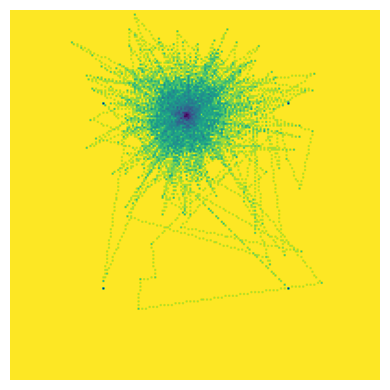

Run no 18, perception         0.5
persistence        0.2
coordination       0.8
repeat               4
success_steps    714.0
Name: 114, dtype: object


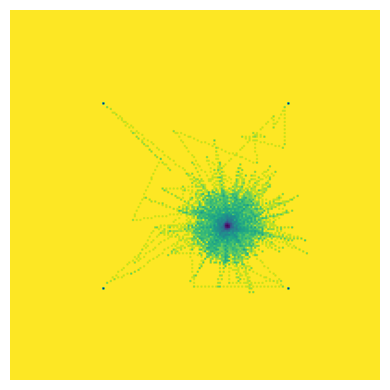

Run no 3, perception         0.5
persistence        0.8
coordination       0.8
repeat               8
success_steps    500.0
Name: 178, dtype: object


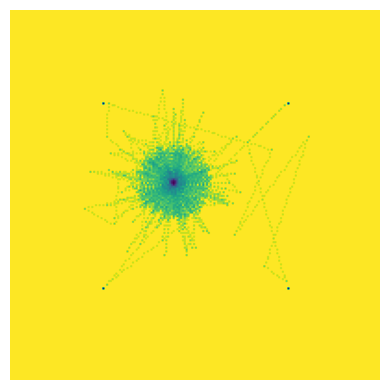

In [101]:
def create_run_position_heatmap(run_index, grid_size, title=""):
    positions = trajectory_df.iloc[run_index, :]["infant_positions"]
    positions = np.array(positions)

    pos_x = positions[:, 0]
    pos_y = positions[:, 1]

    heatmap_data = np.zeros(shape=(grid_size, grid_size))

    bins = np.linspace(0, 100, grid_size + 1)[1:-1]
    indices_x = np.digitize(pos_x, bins)
    indices_y = np.digitize(pos_y, bins)

    indices = zip(indices_x, indices_y)

    for idx in indices:
        heatmap_data[idx] += 1

    toy_value = np.max(heatmap_data)

    for t_x in [25, 75]:
        for t_y in [25, 75]:
            idx_x = np.digitize([t_x], bins)
            idx_y = np.digitize([t_y], bins)

            heatmap_data[idx_x, idx_y] += toy_value

    heatmap_data = np.log1p(heatmap_data)

    create_heatmap(
        heatmap_data,
        param1="x",
        param2="y",
        invert_colors=True,
        show_text=False,
        title=title,
        figsize=(4, 4),
    )


for index in np.random.choice(range(len(trajectory_df)), size=3):
    print(f"Run no {index}, {trajectory_df.iloc[index, :5]}")
    create_run_position_heatmap(index, 200)

Run no 1, perception         0.5
persistence        0.5
coordination       0.8
repeat               4
success_steps    432.0
Name: 144, dtype: object


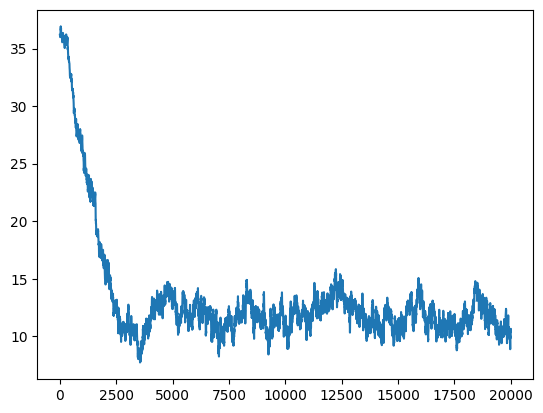

Run no 9, perception         0.2
persistence        0.8
coordination       0.8
repeat               6
success_steps    574.0
Name: 86, dtype: object


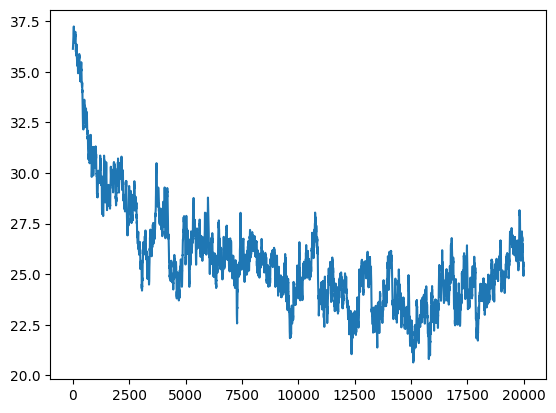

Run no 20, perception         0.5
persistence        0.5
coordination       0.8
repeat               9
success_steps    731.0
Name: 149, dtype: object


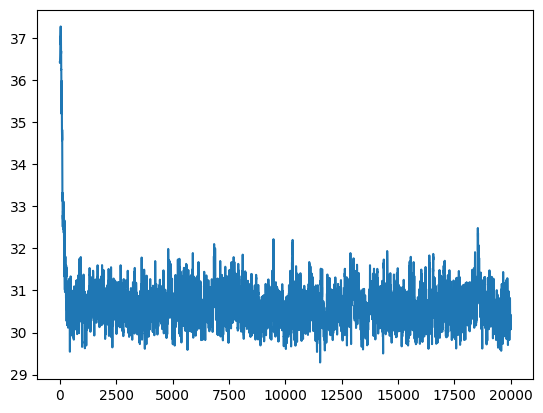

In [92]:
def draw_dist(index):
    data = results_df.iloc[index]["goal_dists"]
    data = np.average(data, axis=0)
    sns.lineplot(data)
    plt.show()


for index in np.random.choice(range(len(results_df)), size=3):
    print(f"Run no {index}, {trajectory_df.iloc[index, :5]}")
    draw_dist(index)

## Determine optimal number of repetitions

### Find out, what distribution the sample came from using Fitter

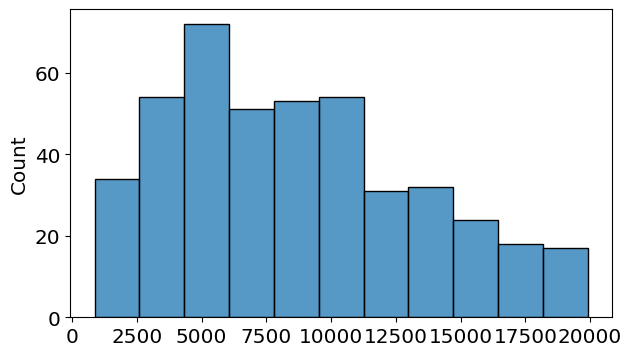

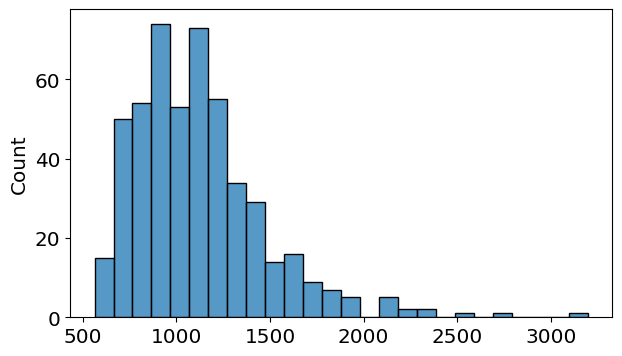

In [114]:
distribution_df = results_df[results_df["success_steps"].notnull()]

for idx, row in distribution_df.sample(2).iterrows():
    sns.histplot(row["success_raw"])
    plt.show()

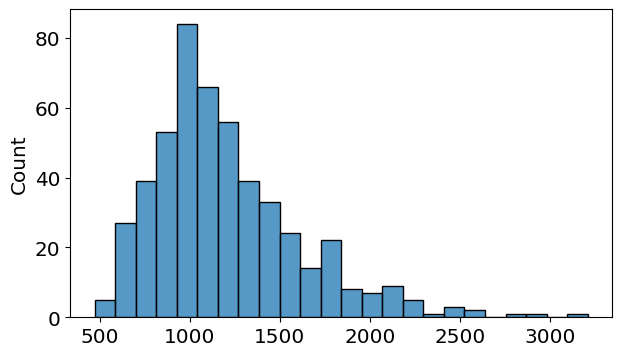

In [115]:
sample = results_df[
    (results_df["persistence"] == 0.5)
    & (results_df["coordination"] == 0.8)
    & (results_df["perception"] == 0.5)
].iloc[0]

success_steps = sample["success_raw"]
success_steps = success_steps[success_steps != 0]

axes = sns.histplot(success_steps)

2024-09-03 08:19:12.348 | WARNING  | fitter.fitter:_fit_single_distribution:337 - SKIPPED _fit distribution (taking more than 120 seconds)
2024-09-03 08:19:12.383 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted anglit distribution with error=1.1e-05)
2024-09-03 08:19:12.383 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted arcsine distribution with error=1.8e-05)
2024-09-03 08:19:12.387 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted bradford distribution with error=1e-05)
2024-09-03 08:19:12.389 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted alpha distribution with error=1e-06)
2024-09-03 08:19:12.393 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted betaprime distribution with error=1e-06)
2024-09-03 08:19:12.397 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted argus distribution with error=1.8e-05)
2024-09-03 08:19:12.399 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted 

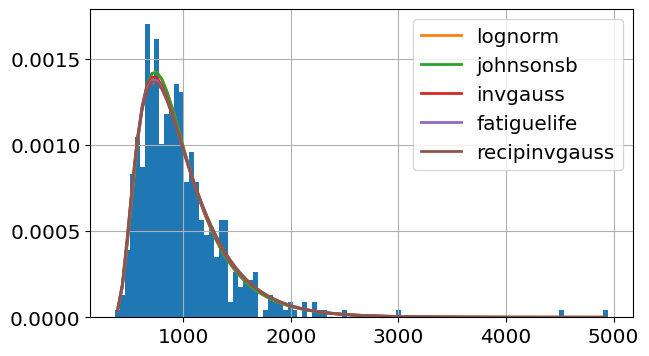

best fit: {'lognorm': {'s': 0.5285614174909118, 'loc': 278.1964253499572, 'scale': 608.756708432808}}


In [21]:
f = Fitter(success_steps, timeout=120)
f.fit()
f.summary()
plt.show()

print(f"best fit: {f.get_best(method="sumsquare_error")}")

In [46]:
f.df_errors.sort_values("sumsquare_error").head(25)

sumsquare_error          aic          bic  kl_div  \
lognorm           8.455482e-07  2258.661953  2271.305777     inf   
johnsonsb         8.462766e-07  2263.947399  2280.805832     inf   
invgauss          8.585846e-07  2318.574762  2331.218586     inf   
fatiguelife       8.633474e-07  2349.525266  2362.169090     inf   
recipinvgauss     8.669301e-07  2365.443950  2378.087775     inf   
invgamma          8.675924e-07  2206.630413  2219.274237     inf   
johnsonsu         8.692216e-07  2229.327359  2246.185791     inf   
exponweib         8.725631e-07  2218.565032  2235.423465     inf   
moyal             8.805509e-07  2375.301735  2383.730951     inf   
f                 8.868700e-07  2278.227129  2295.085562     inf   
betaprime         8.879908e-07  2281.533272  2298.391705     inf   
norminvgauss      8.902597e-07  2262.296209  2279.154641     inf   
jf_skew_t         8.915559e-07  2189.306168  2206.164601     inf   
gengamma          8.948557e-07  2190.648079  2207.506512     inf   
invweibull        8.982376e-07  2187.434818  2200.078643     inf   
nct               9.125811e-07  2172.586613  2189.445045     inf   
alpha             9.197396e-07  2171.530800  2184.174624     inf   
genhyperbolic     9.375290e-07  2176.912560  2197.985601     inf   
fisk              9.903390e-07  2128.561664  2141.205489     inf   
erlang            1.012393e-06  2509.522976  2522.166800     inf   
pearson3          1.012674e-06  2508.471680  2521.115504     inf   
exponnorm         1.013039e-06  2276.356283  2289.000107     inf   
mielke            1.022035e-06  2145.183403  2162.041835     inf   
beta              1.052547e-06  2837.586166  2854.444598     inf   
genlogistic       1.114667e-06  2552.211297  2564.855121     inf   

               ks_statistic  ks_pvalue  
lognorm            0.022534   0.956424  
johnsonsb          0.023075   0.947156  
invgauss           0.023812   0.932808  
fatiguelife        0.026824   0.854812  
recipinvgauss      0.028451   0.802077  
invgamma           0.026398   0.867539  
johnsonsu          0.027771   0.824829  
exponweib          0.027729   0.826226  
moyal              0.026762   0.856692  
f                  0.027812   0.823496  
betaprime          0.027283   0.840553  
norminvgauss       0.028971   0.784118  
jf_skew_t          0.027789   0.824236  
gengamma           0.028094   0.814163  
invweibull         0.028196   0.810717  
nct                0.034385   0.583320  
alpha              0.024990   0.905832  
genhyperbolic      0.027823   0.823127  
fisk               0.026288   0.870769  
erlang             0.044172   0.275245  
pearson3           0.043913   0.281604  
exponnorm          0.037441   0.473615  
mielke             0.035741   0.533566  
beta               0.046327   0.226402  
genlogistic        0.046986   0.212857

### Check null hypothesis - the distribution does not follow lognorm

In [116]:
from scipy import stats
from scipy.stats import lognorm


def check_null_hypothesis(x):
    f = Fitter(x, distributions=["lognorm"], timeout=120)
    f.fit()

    args = f.fitted_param["lognorm"]

    k_test_result = stats.ks_1samp(x, lognorm.cdf, args=args)
    return k_test_result.pvalue

In [117]:
p_values = []

for i, row in distribution_df.iterrows():
    success_steps = row["success_raw"]
    success_steps = success_steps[success_steps != 0]
    success_steps = success_steps[~np.isnan(success_steps)]

    p_values.append(check_null_hypothesis(success_steps))

2024-09-03 10:44:43.160 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted lognorm distribution with error=0.0)
2024-09-03 10:44:43.179 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted lognorm distribution with error=0.0)
2024-09-03 10:44:43.189 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted lognorm distribution with error=0.0)
2024-09-03 10:44:43.202 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted lognorm distribution with error=0.0)
2024-09-03 10:44:43.217 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted lognorm distribution with error=1e-06)
2024-09-03 10:44:43.231 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted lognorm distribution with error=1e-06)
2024-09-03 10:44:43.245 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted lognorm distribution with error=1e-06)
2024-09-03 10:44:43.263 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted lognorm distribution wi

Any p-value < 0.05 ?: False


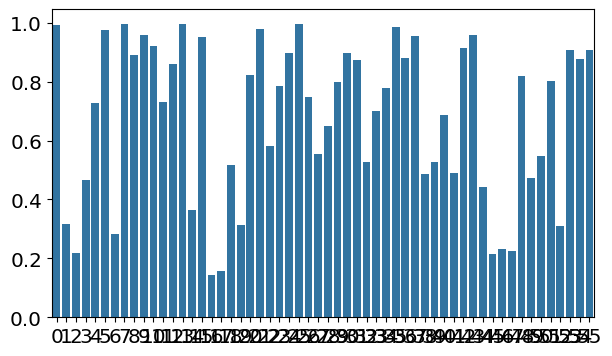

In [118]:
sns.barplot(p_values)
print(f"Any p-value < 0.05 ?: {any(np.array(p_values) < 0.05)}")

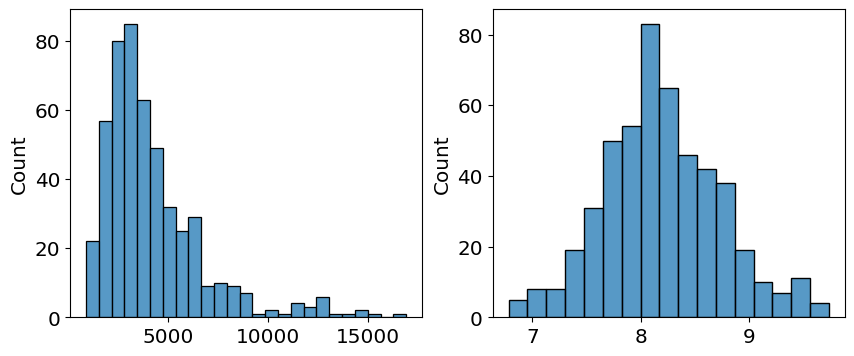

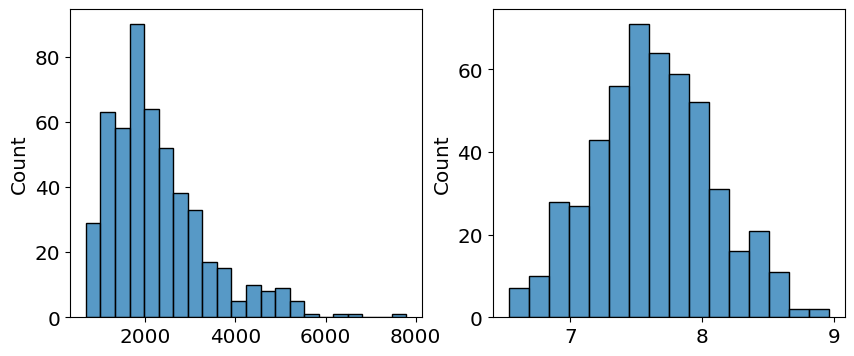

In [119]:
for i, row in distribution_df.sample(2).iterrows():
    success_steps = row["success_raw"]
    success_steps = success_steps[success_steps != 0]

    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    sns.histplot(success_steps, ax=ax[0])
    sns.histplot(np.log(success_steps), ax=ax[1])
    plt.show()

In [120]:
def get_mean_std(row):
    success_steps = row["success_raw"]
    success_steps = success_steps[~np.isnan(success_steps)]
    log = np.log(success_steps)

    return np.mean(log), np.std(log)


mean, std = zip(*[get_mean_std(row) for i, row in distribution_df.iterrows()])

distribution_df.loc[:, "log_mean"] = mean
distribution_df.loc[:, "std"] = std

/var/folders/5f/kqrh3s354fl8g41k0s312pgh0000gn/T/ipykernel_78660/1026737561.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  distribution_df.loc[:, "log_mean"] = mean
/var/folders/5f/kqrh3s354fl8g41k0s312pgh0000gn/T/ipykernel_78660/1026737561.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  distribution_df.loc[:, "std"] = std


In [121]:
distribution_df.sample(3)

perception  persistence  coordination  persistence_boost_value  \
34         0.2          0.8           0.8                 0.666667   
54         0.5          0.5           0.5                 0.666667   
16         0.2          0.5           0.5                 0.000000   

    coordination_boost_value  \
34                  0.666667   
54                  0.666667   
16                  0.000000   

                                         infant_class  \
34  <class 'infant_abm.agents.abstract_vision.abst...   
54  <class 'infant_abm.agents.abstract_vision.abst...   
16  <class 'infant_abm.agents.abstract_vision.abst...   

                                         parent_class  success_steps  \
34  <class 'infant_abm.agents.abstract_vision.abst...        928.820   
54  <class 'infant_abm.agents.abstract_vision.abst...       2387.030   
16  <class 'infant_abm.agents.abstract_vision.abst...       2320.258   

                                          success_raw  log_mean       std  
34  [861.0, 1005.0, 690.0, 793.0, 819.0, 862.0, 64...  6.800350  0.252295  
54  [3564.0, 1534.0, 4762.0, 4311.0, 2107.0, 4322....  7.677661  0.444567  
16  [2732.0, 2013.0, 4664.0, 3899.0, 1883.0, 2601....  7.648301  0.444008

### Calculate mean and standard deviation of the deviations

In [122]:
rel_error = [0.05, 0.02, 0.01]
for err in rel_error:
    num_samples = []

    for _i, row in distribution_df[~distribution_df["std"].isnull()].iterrows():
        # abs_err = row["log_mean"] * err
        abs_err = np.log(err + 1)
        num_samples.append((1.645 * row["std"] / abs_err) ** 2)

    print(
        f"Number of samples for relative error of {err} = {int(np.average(num_samples) + 1)}, {int(np.max(num_samples) + 1)}"
    )
    # print(f"95% confidence range in original distribution = {}")

Number of samples for relative error of 0.05 = 214, 516
Number of samples for relative error of 0.02 = 1299, 3127
Number of samples for relative error of 0.01 = 5144, 12383


## Basic analysis

216
[(0, 1), (0, 1), (0, 1)]


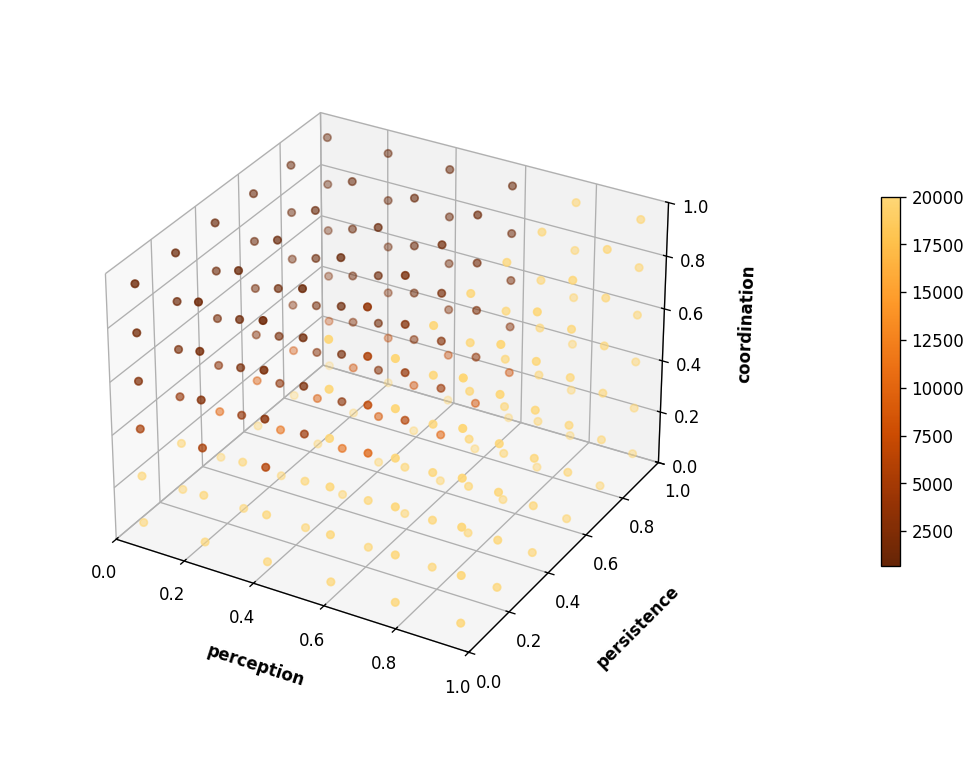

In [9]:
fig = plt.figure(figsize=(28, 8), dpi=120)
ax = fig.add_subplot(1, 1, 1, projection="3d")

no_boost_df = results_df[results_df["persistence_boost_value"] == 0.0]
print(len(no_boost_df))

color = np.nan_to_num(no_boost_df["success_steps"].to_numpy(), nan=ITERATIONS)

plot = plot_params_3d(
    ax,
    no_boost_df,
    c=color,
    s=20,
)

axes = fig.axes

colorbar = fig.colorbar(plot, ax=axes, shrink=0.5, location="right")
# ax.set_title(f"Impact of parameters on success, model {MODEL}", size="18")

plt.show()

## Show runs which were improved by boost

In [11]:
improvement_df = results_df

improvement = []

for params, row in improvement_df.groupby(
    by=["perception", "persistence", "coordination"]
):
    success_steps = row["success_steps"].to_numpy()

    if success_steps[0] < np.min(success_steps):
        improvement_df = improvement_df.drop(index=row.index)

    else:
        base_value = success_steps[0]

        for index, success in zip(row.index, row["success_steps"]):
            improvement.append(1 - (success / base_value))


print(len(improvement_df))


improvement_df["improvement"] = improvement
# improvement_df[improvement_df.iloc[:, 0:3] == [0.1, np.NaN, 0.5]]
improvement_df.sort_values("improvement")
# improvement_df.iloc[45:65]

1080


perception  persistence  coordination  persistence_boost_value  \
596         0.59         0.23          0.95                     0.25   
371         0.41         0.05          0.41                     0.25   
591         0.59         0.23          0.77                     0.25   
586         0.59         0.23          0.59                     0.25   
386         0.41         0.05          0.95                     0.25   
...          ...          ...           ...                      ...   
1075        0.95         0.95          0.95                     0.00   
1076        0.95         0.95          0.95                     0.25   
1077        0.95         0.95          0.95                     0.50   
1078        0.95         0.95          0.95                     0.75   
1079        0.95         0.95          0.95                     1.00   

      coordination_boost_value  success_steps  improvement  
596                       0.25     5981.84265    -0.597804  
371                       0.25     8478.75776    -0.411249  
591                       0.25     7723.16977    -0.408051  
586                       0.25     9022.84058    -0.353126  
386                       0.25     1727.18219    -0.289996  
...                        ...            ...          ...  
1075                      0.00            NaN          NaN  
1076                      0.25            NaN          NaN  
1077                      0.50            NaN          NaN  
1078                      0.75            NaN          NaN  
1079                      1.00            NaN          NaN  

[1080 rows x 7 columns]

In [12]:
fig = plt.figure(figsize=(10, 10), dpi=120)
ax = fig.add_subplot(1, 1, 1, projection="3d")

data = []

for params, row in improvement_df[
    ["perception", "persistence", "coordination", "improvement"]
].groupby(["perception", "persistence", "coordination"]):
    data.append(list(params) + [row["improvement"].max()])

plot_df = pd.DataFrame(
    data,
    columns=["perception", "persistence", "coordination", "improvement"],
)

all_nan_count = 0

for params, row in results_df[
    ["perception", "persistence", "coordination", "success_steps"]
].groupby(["perception", "persistence", "coordination"]):
    # if np.all(np.isnan(row["success_steps"])):
    all_nan_count += 1

print(all_nan_count)


plot = plot_params_3d(
    ax,
    plot_df,
    c=plot_df["improvement"],
    s=20,
)

axes = fig.axes

fig.colorbar(plot, ax=axes, shrink=0.5, location="right")
plt.show()

216
[(0, 1), (0, 1), (0, 1)]


In [14]:
plot_df.sort_values("improvement", ascending=False)

perception  persistence  coordination  improvement
55         0.23         0.59          0.23     0.110515
141        0.59         0.95          0.59     0.091281
8          0.05         0.23          0.41     0.079292
104        0.41         0.95          0.41     0.075258
98         0.41         0.77          0.41     0.068122
..          ...          ...           ...          ...
211        0.95         0.95          0.23          NaN
212        0.95         0.95          0.41          NaN
213        0.95         0.95          0.59          NaN
214        0.95         0.95          0.77          NaN
215        0.95         0.95          0.95          NaN

[216 rows x 4 columns]

In [102]:
x = []
y_s = []


for params, row in improvement_df.groupby(
    ["perception", "persistence", "coordination", "improvement"]
):
    x.append(params[0])
    y_s.append(row["improvement"].to_numpy())


# for y in y_s:
#     ax.bar(x, y, width=0.2, color="b", align="center")

# plt.show()

boost = improvement_df["persistence_boost_value"].unique()

groupby = improvement_df.groupby(["perception", "persistence", "coordination"])

x = boost[1:]  # the label locations
width = 0.002  # the width of the bars
multiplier = -len(groupby) / 2

fig, ax = plt.subplots(layout="constrained")

for params, row in groupby:
    improvement = row["improvement"].to_numpy()[1:]

    offset = width * multiplier
    rects = ax.bar(x + offset, improvement, width)
    multiplier += 1

mean = (
    improvement_df.groupby(["persistence_boost_value"]).mean()["improvement"].to_numpy()
)
mean = np.round(mean, 4)

improvement = row["improvement"].to_numpy()[1:]

offset += width * 5
rects = ax.bar(x + offset, mean[1:], width * 5)
ax.bar_label(rects, padding=3)


ax.set_ylabel("Improvement ratio")
ax.set_title("Improvement when using boost")
ax.set_xticks(x + width, boost[1:])

plt.show()

In [26]:
fig = plt.figure(figsize=(24, 10), dpi=120)

BEST_PERCENT = 15
BEST_N_POINTS = int(BEST_PERCENT / 100 * N_SAMPLES)

selected_df = [dataframes[i] for i in [0, 2, 4]]


for i, (name, df) in enumerate(selected_df):
    boost_value = np.round(int(name[-3:]) / 100, 2)

    points = (
        df.sort_values("success_steps")
        .head(BEST_N_POINTS)[
            ["perception", "persistence", "coordination", "success_steps"]
        ]
        .to_numpy()
    )

    ax = fig.add_subplot(1, N_POINTS, i + 1, projection="3d")

    x, y, z, target = zip(*points)

    plot = plot_params_3d(
        ax,
        x,
        y,
        z,
        title=f"Best params, boost={boost_value}",
        c=target,
        s=20,
        vmin=0,
        vmax=1 / 8 * ITERATIONS,
    )

axes = fig.axes

fig.colorbar(plot, ax=axes, shrink=0.67, location="bottom")
fig.suptitle(f"Best {BEST_PERCENT}% runs", size="20")

plt.show()

NameError: name 'N_SAMPLES' is not defined

<Figure size 2880x1200 with 0 Axes>

In [156]:
fig = plt.figure(figsize=(24, 10), dpi=120)

LAST_PERCENT = 75
LAST_N_POINTS = int(LAST_PERCENT / 100 * N_SAMPLES)

for i, (name, df) in enumerate(selected_df):
    boost_value = np.round(int(name[-3:]) / 100, 2)

    df["success_steps"] = df["success_steps"].fillna(ITERATIONS)

    points = (
        df.sort_values("success_steps")
        .tail(LAST_N_POINTS)[
            ["perception", "persistence", "coordination", "success_steps"]
        ]
        .to_numpy()
    )

    ax = fig.add_subplot(1, N_POINTS, i + 1, projection="3d")

    x, y, z, target = zip(*points)

    plot = plot_params_3d(
        ax,
        x,
        y,
        z,
        title=f"Best params, boost={boost_value}",
        c=target,
        vmin=3 / 4 * ITERATIONS,
        vmax=ITERATIONS,
    )

axes = fig.axes

cbar = fig.colorbar(plot, ax=axes, shrink=0.67, location="bottom")
fig.suptitle(f"Worst {LAST_PERCENT}% runs", size="20")
plt.show()

/var/folders/5f/kqrh3s354fl8g41k0s312pgh0000gn/T/ipykernel_14598/1418142149.py:10: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plot = ax.scatter3D(x, y, z, cmap=plt.get_cmap("viridis_r"), s=s, **kwargs)
/var/folders/5f/kqrh3s354fl8g41k0s312pgh0000gn/T/ipykernel_14598/1418142149.py:10: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plot = ax.scatter3D(x, y, z, cmap=plt.get_cmap("viridis_r"), s=s, **kwargs)


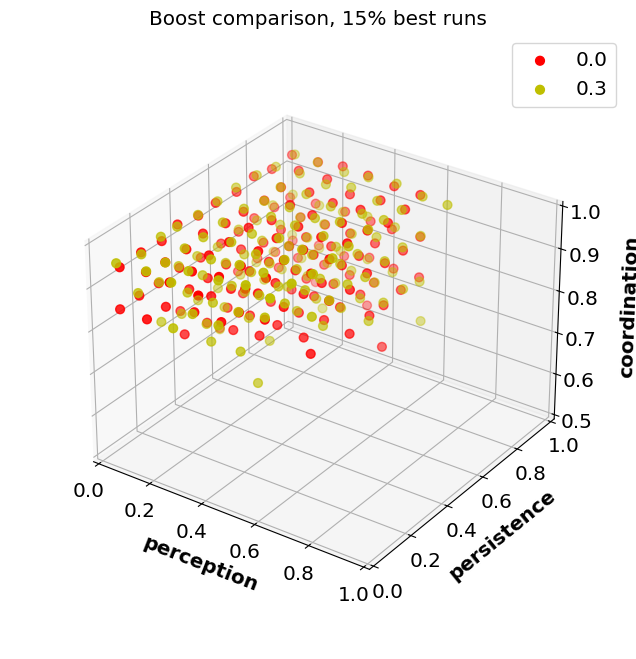

In [122]:
selected_df = [dataframes[i] for i in [0, 2]]
colors = ["r", "y", "b"]

JITTER = 0.008

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(projection="3d")

for i, (name, df) in enumerate(selected_df):
    boost_value = np.round(int(name[-3:]) / 100, 2)

    points = (
        df.sort_values("success_steps")
        .head(BEST_N_POINTS)[["perception", "persistence", "coordination"]]
        .to_numpy()
    )

    x, y, z = zip(*points)

    x += np.random.uniform(-JITTER, JITTER, len(x))
    y += np.random.uniform(-JITTER, JITTER, len(y))
    z += np.random.uniform(-JITTER, JITTER, len(z))

    c = [colors[i] for _ in range(len(x))]

    plot = plot_params_3d(ax, x, y, z, coord_lim=[0.5, 1], color=c)
    plot.set_label(boost_value)

ax.set_title(f"Boost comparison, {BEST_PERCENT}% best runs")
ax.legend()
ax.view_init(30, -55)

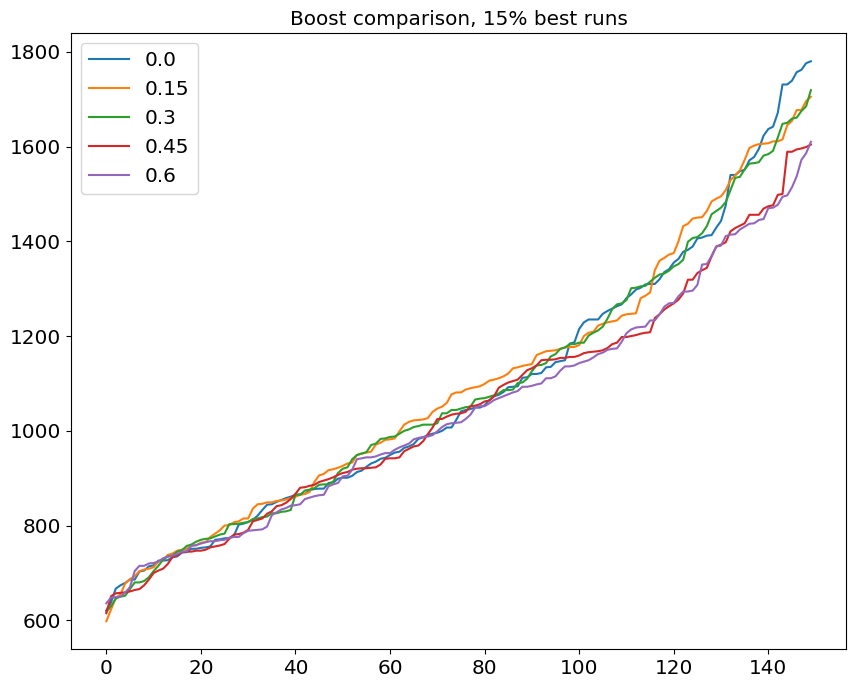

In [123]:
selected_df = [dataframes[i] for i in [0, 1, 2, 3, 4]]

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot()

for i, (name, df) in enumerate(selected_df):
    boost_value = np.round(int(name[-3:]) / 100, 2)

    points = (
        df.sort_values("success_steps")
        .head(BEST_N_POINTS)[["success_steps"]]
        .to_numpy()
    )

    plot = ax.plot(np.arange(len(points)), points, label=boost_value)

ax.set_title(f"Boost comparison, {BEST_PERCENT}% best runs")
ax.legend()

### See in how many cases, the increase in boost value resulted in better results

In [33]:
boost_values = results_df["persistence_boost_value"].unique()[1:]
selected_df = [
    results_df[results_df["persistence_boost_value"] == bst] for bst in boost_values
]
baseline_df = results_df[results_df["persistence_boost_value"] == 0]

index = [10, 20, 50, 100]

plot_map = {0.0: []}

for i, df in enumerate(selected_df):
    [boost_value] = df["persistence_boost_value"].unique()
    plot_map[boost_value] = []

index = ["perception", "persistence", "coordination"]

for n_best_points in index:
    boost_cmp_df = baseline_df.sort_values("success_steps").head(n_best_points)[
        ["success_steps"]
    ]

    boost_cmp_df.set_index(index)

    plot_map[0.0].append(np.average(boost_cmp_df["success_steps"]))

    for i, df in enumerate(selected_df):
        [boost_value] = df["persistence_boost_value"].unique()

        boost_cmp_df[name] = df.loc[
            baseline_df.index[["perception", "persistence", "coordination"]]
        ]["success_steps"]

        better_runs = len(
            boost_cmp_df[boost_cmp_df[name] > boost_cmp_df["success_steps"]]
        )
        plot_map[boost_value].append(np.average(boost_cmp_df[name]))

print(plot_map)


axis_x = []
success_steps = []

successful_results_df = results_df[results_df["success_steps"].notnull()]

for n_best_points in index:
    for boost_value, row in results_df.groupby(by="persistence_boost_value"):
        # axis_x.append(np.round(boost_value, 3))

        plot_map[0.0].append(np.average(boost_cmp_df["success_steps"]))

        success_steps.append(row["success_steps"].mean())


# f, ax1 = plt.subplots(figsize=(8, 4))
# ax1.bar(
#     axis_x,
#     success_steps,
#     width=0.08,
# )
# ax1.set_xlabel("Boost value")
# ax1.set_ylabel("Success steps")
# ax1.set_title("Persistence boost ratio")
# ax1.set_ylim(
#     bottom=min(success_steps) - 100,
#     top=max(success_steps) + 100,
# )
# ax1.set_xticks(axis_x)


plot_df = pd.DataFrame(plot_map, index=index)
ax = plot_df.plot.bar(rot=0)
plt.legend(bbox_to_anchor=(-0.1, 1))

IndexError: positional indexers are out-of-bounds

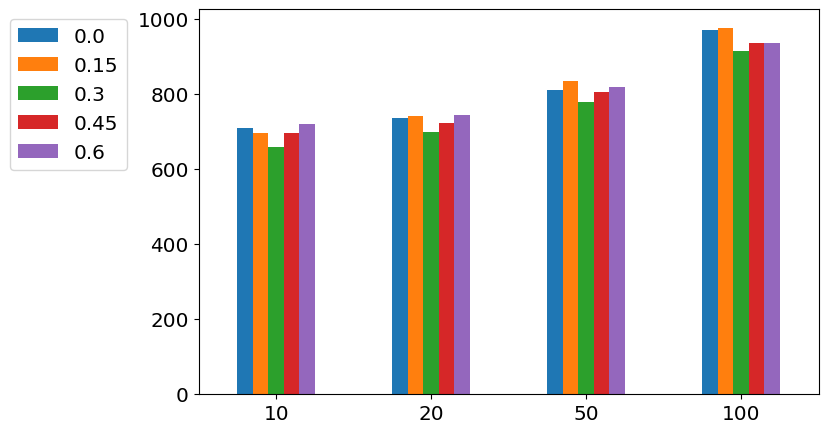

In [50]:
selected_df = [dataframes[i] for i in [0, 1, 2]]
baseline_df = dataframes[0][1]

index = [10, 20, 50, 100]

for i, (name, df) in enumerate(selected_df):
    boost_value = np.round(int(name[-3:]) / 100, 2)
    plot_map[boost_value] = []

for n_best_points in index:
    boost_cmp_df = df.sort_values("success_steps").head(n_best_points)[
        ["success_steps"]
    ]

    for i, (name, df) in enumerate(selected_df):
        boost_value = np.round(int(name[-3:]) / 100, 2)

        boost_cmp_df[name] = df.iloc[baseline_df.index]["success_steps"]

        better_runs = boost_cmp_df[
            boost_cmp_df[name] > boost_cmp_df["success_steps"]
        ].shape[0]
        plot_map[boost_value].append(np.average(boost_cmp_df[name]))


plot_df = pd.DataFrame(plot_map, index=index)
ax = plot_df.plot.bar(rot=0)
plt.legend(bbox_to_anchor=(-0.1, 1))

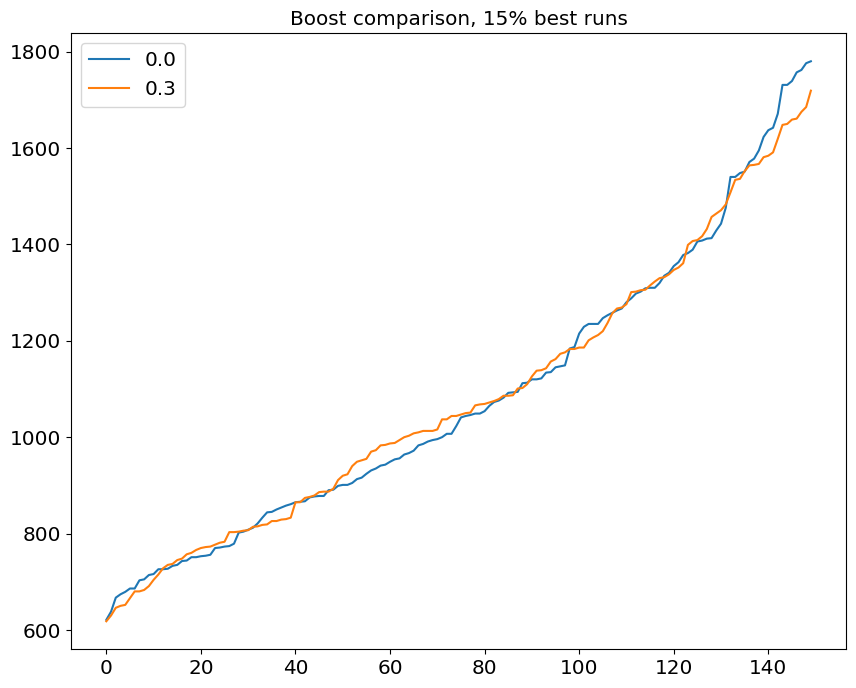

In [51]:
selected_df = [dataframes[i] for i in [0, 2]]

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot()

for i, (name, df) in enumerate(selected_df):
    boost_value = np.round(int(name[-3:]) / 100, 2)

    points = (
        df.sort_values("success_steps")
        .head(BEST_N_POINTS)[["success_steps"]]
        .to_numpy()
    )

    plot = ax.plot(np.arange(len(points)), points, label=boost_value)

ax.set_title(f"Boost comparison, {BEST_PERCENT}% best runs")
ax.legend()

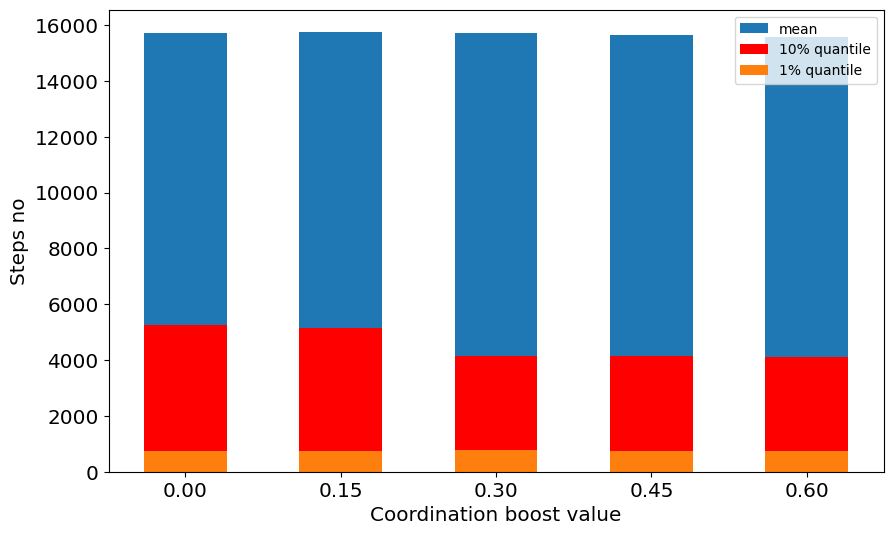

In [52]:
axis_x = []
y_mean = []
y_quantiles = np.zeros(shape=(len(dataframes), 99))

for i, (name, df) in enumerate(dataframes):
    axis_x.append(np.round(int(name[-3:]) / 100, 3))

    goal = df["success_steps"]
    goal = goal.fillna(ITERATIONS)

    y_mean.append(statistics.mean(goal))
    y_quantiles[i] = statistics.quantiles(goal, n=100)


f, ax1 = plt.subplots(figsize=(10, 6))
ax1.bar(axis_x, y_mean, width=0.08, label="mean")
ax1.set_xlabel("Coordination boost value")
ax1.set_ylabel("Steps no")

ax2 = plt.subplot()
ax2.bar(axis_x, y_quantiles[:, 20], width=0.08, label="10% quantile", color="r")
ax2.set_xticks(axis_x)

ax3 = plt.subplot()
ax3.bar(axis_x, y_quantiles[:, 1], width=0.08, label="1% quantile")
ax3.set_xticks(axis_x)
ax3.legend(prop={"size": 10})

results/basic_01_09_3/basic




perception  persistence  coordination  repeats  iterations  \
8          0.1          0.9           0.9        4       20000   
17         0.5          0.9           0.9        4       20000   
5          0.1          0.5           0.9        4       20000   
14         0.5          0.5           0.9        4       20000   
2          0.1          0.1           0.9        4       20000   
11         0.5          0.1           0.9        4       20000   

                                              actions  \
8   {'LookForToy': 8753, 'EvaluateToy': 18151, 'Cr...   
17  {'LookForToy': 8632, 'EvaluateToy': 18120, 'Cr...   
5   {'LookForToy': 8824, 'EvaluateToy': 19036, 'Cr...   
14  {'LookForToy': 8991, 'EvaluateToy': 19044, 'Cr...   
2   {'LookForToy': 9190, 'EvaluateToy': 19738, 'Cr...   
11  {'LookForToy': 8891, 'EvaluateToy': 19353, 'Cr...   

                                           infant_pos  success_steps  
8   ([[50.0, 50.0], [50.0, 50.0], [50.0, 50.0], [5...          739.0  
17  ([[50.0, 50.0], [50.0, 50.0], [50.0, 50.0], [5...          748.0  
5   ([[50.0, 50.0], [50.0, 50.0], [50.0, 50.0], [5...          936.0  
14  ([[50.0, 50.0], [50.0, 50.0], [50.0, 50.0], [5...          997.0  
2   ([[50.0, 50.0], [50.0, 50.0], [50.0, 50.0], [5...         1305.0  
11  ([[50.0, 50.0], [50.0, 50.0], [50.0, 50.0], [5...         2125.0

success runs 6
Best: 739.0 Mean: 15809.25925925926


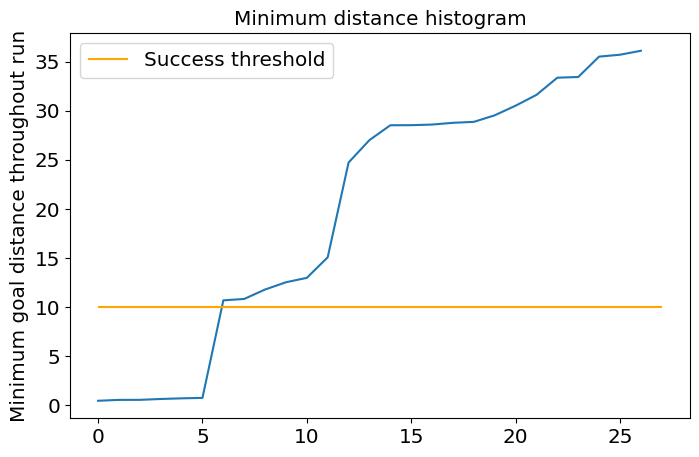

9


AssertionError: 

In [12]:
from statistics import mean

GRID_SIZE = 10


def draw_min_dist_histogram(df):
    y = (
        df.apply(lambda row: np.min(row["goal_distance"]), axis=1)
        .sort_values()
        .to_numpy()
    )

    fig, ax = plt.subplots()
    ax.plot(y)
    ax.set_title("Minimum distance histogram")
    ax.set_ylabel("Minimum goal distance throughout run")
    ax.hlines(
        y=SUCCESS_DIST, xmin=0, xmax=len(y), color="orange", label="Success threshold"
    )
    ax.legend()
    plt.show()


def get_heatmap_data(paramx, paramy, df):
    heatmap_data = np.zeros(shape=(GRID_SIZE, GRID_SIZE))
    # paramx = "perception"
    # paramy = "persistence"

    grouped = df_fill_na.groupby([paramy, paramx])
    # display(grouped.mean())

    # display(df_fill_na.sort_values(by=[paramx, paramy]))

    print(len(grouped))

    labelsx = []
    labelsy = []

    for idx, (name, group) in enumerate(grouped):
        # print(idx, idx // 5)

        value = group["success_steps"].mean()

        (p1, p2) = name

        if idx % GRID_SIZE == 0:
            labelsx.append(np.round(p1, 4))

        if idx // GRID_SIZE == 0:
            labelsy.append(np.round(p2, 4))

        heatmap_data[idx // GRID_SIZE, idx % GRID_SIZE] = value

    return labelsx, labelsy, heatmap_data


SUCCESS_DIST = 10

for name, df in dataframes:
    print(f"{name}\n\n")

    df["success_steps"] = df.apply(
        lambda row: get_success_step(row["goal_distance"], SUCCESS_DIST), axis=1
    )

    df_non_na = df[df["success_steps"].notnull()].sort_values(by=["success_steps"])
    display(
        df_non_na.head(10).drop(columns=["parent_tps", "infant_tps", "goal_distance"])
    )
    print(f"success runs {len(df_non_na)}")

    goal = df["success_steps"]
    goal = goal.fillna(ITERATIONS)
    best_result = sorted(goal)[0]

    print(f"Best: {best_result} Mean: {mean(goal)}")

    draw_min_dist_histogram(df)

    df_fill_na = df
    df_fill_na[["success_steps"]] = df[["success_steps"]].fillna(ITERATIONS)
    # display(df_fill_na)
    # grouped = df_fill_na.groupby(["perception", "persistence"])

    for paramx, paramy in [
        ("perception", "persistence"),
        ("perception", "coordination"),
        ("persistence", "coordination"),
    ]:
        labelsx, labelsy, heatmap_data = get_heatmap_data(paramx, paramy, df_fill_na)

        create_heatmap(
            heatmap_data,
            paramx,
            paramy,
            labelsx,
            labelsy,
            invert_colors=True,
            figsize=(8, 8),
        )

## Which boost value yielded best results ?

### Successful runs

In [93]:
def plot_boost_effect(x, y, label=None):
    axes = sns.scatterplot(x=axis_x, y=success_steps)

    axes.set_xlabel("Boost value")
    axes.set_ylabel("Success steps")
    # axes.set_title("Boost value")
    axes.set_xticks(axis_x)

    return axes


axis_x = []
success_steps = []

successful_results_df = results_df

for boost_value, row in successful_results_df.groupby(by="coordination_boost_value"):
    axis_x.append(np.round(boost_value, 3))
    success_steps.append(row["success_steps"].mean())

plot_boost_effect(axis_x, success_steps)

<Axes: xlabel='Boost value', ylabel='Success steps'>

### Try top N runs

In [94]:
boost_values = successful_results_df["persistence_boost_value"].unique()

n_bests = [5, 10, 20, 30]
for n_best in n_bests:
    axis_x = []
    success_steps = []

    for boost_value in boost_values:
        success_value = (
            results_df[results_df["persistence_boost_value"] == boost_value]
            .sort_values("success_steps")
            .head(n_best)["success_steps"]
            .mean()
        )

        axis_x.append(np.round(boost_value, 3))
        success_steps.append(success_value)

    axes = plot_boost_effect(axis_x, success_steps, label=n_best)
axes.legend(
    n_bests, loc="center left", title="No best samples", bbox_to_anchor=(1, 0.8)
)

## Boost frequency - how often we get boost

In [75]:
def get_boost_count(index):
    if index % 100 == 0:
        print(index)
    results = load_partial(index).values()

    boost_events = np.array([r["boosts"] for r in results])
    boost

    return [
        np.average(np.array(boost_events == name, dtype="int"), axis=0)
        for name in boost_names
    ]

    return


boost_names = [
    "persistence",
    "no_persistence",
    "coordination",
    "no_coordination",
]

new_column_names = [f"{boost}_boost_count" for boost in boost_names]

if not all([name in boost_freq_df.columns for name in new_column_names]):
    boost_freq_df = results_df

    boost_freq_df[new_column_names] = [
        get_boost_count(index) for index in boost_freq_df.index
    ]

for boost_name in ["persistence", "coordination"]:
    a = np.array(boost_freq_df[f"{boost_name}_boost_count"].to_list()).sum(axis=1)
    b = np.array(boost_freq_df[f"no_{boost_name}_boost_count"].to_list()).sum(axis=1)

    boost_freq_df[f"{boost_name}_boost_ratio"] = a / (a + b)

display(boost_freq_df.sort_values("persistence_boost_ratio", ascending=False).head())
display(boost_freq_df.sort_values("coordination_boost_ratio", ascending=False).tail())

perception  persistence  coordination  persistence_boost_value  \
595         0.9          0.7           0.9                     0.00   
599         0.9          0.7           0.9                     1.00   
621         0.9          0.9           0.9                     0.25   
623         0.9          0.9           0.9                     0.75   
596         0.9          0.7           0.9                     0.25   

     coordination_boost_value  success_steps  \
595                      0.00        20000.0   
599                      1.00        20000.0   
621                      0.25        20000.0   
623                      0.75        20000.0   
596                      0.25        20000.0   

                               persistence_boost_count  \
595  [0.0, 0.0, 0.09090909090909091, 0.0, 0.1818181...   
599  [0.0, 0.0, 0.18181818181818182, 0.181818181818...   
621  [0.0, 0.0, 0.09090909090909091, 0.090909090909...   
623  [0.0, 0.0, 0.09090909090909091, 0.0, 0.1818181...   
596  [0.0, 0.09090909090909091, 0.09090909090909091...   

                            no_persistence_boost_count  \
595  [0.0, 0.0, 0.0, 0.0, 0.7272727272727273, 0.0, ...   
599  [0.0, 0.0, 0.0, 0.0, 0.36363636363636365, 0.0,...   
621  [0.0, 0.0, 0.0, 0.0, 0.7272727272727273, 0.0, ...   
623  [0.0, 0.0, 0.0, 0.0, 0.7272727272727273, 0.0, ...   
596  [0.0, 0.0, 0.0, 0.0, 0.5454545454545454, 0.0, ...   

                              coordination_boost_count  \
595  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
599  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
621  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
623  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
596  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                           no_coordination_boost_count  \
595  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
599  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
621  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
623  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
596  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

     persistence_boost_ratio  coordination_boost_ratio  persistence_ratio  \
595                 0.882653                  0.856226           7.521752   
599                 0.881213                  0.856949           7.418436   
621                 0.880788                  0.851287           7.388398   
623                 0.880537                  0.855358           7.370770   
596                 0.880148                  0.857936           7.343651   

     coordination_ratio  
595            5.955372  
599            5.990532  
621            5.724350  
623            5.913631  
596            6.039105

perception  persistence  coordination  persistence_boost_value  \
326         0.5          0.7           0.1                     0.25   
228         0.3          0.9           0.1                     0.75   
77          0.1          0.7           0.1                     0.50   
102         0.1          0.9           0.1                     0.50   
351         0.5          0.9           0.1                     0.25   

     coordination_boost_value  success_steps  \
326                      0.25        20000.0   
228                      0.75        20000.0   
77                       0.50        20000.0   
102                      0.50        20000.0   
351                      0.25        20000.0   

                               persistence_boost_count  \
326  [0.0, 0.0, 0.18181818181818182, 0.272727272727...   
228  [0.0, 0.0, 0.18181818181818182, 0.272727272727...   
77   [0.0, 0.0, 0.18181818181818182, 0.090909090909...   
102  [0.0, 0.09090909090909091, 0.09090909090909091...   
351  [0.0, 0.0, 0.2727272727272727, 0.0, 0.0, 0.0, ...   

                            no_persistence_boost_count  \
326  [0.0, 0.0, 0.0, 0.0, 0.2727272727272727, 0.0, ...   
228  [0.0, 0.0, 0.0, 0.0, 0.45454545454545453, 0.0,...   
77   [0.0, 0.0, 0.0, 0.0, 0.6363636363636364, 0.0, ...   
102  [0.0, 0.0, 0.0, 0.0, 0.5454545454545454, 0.0, ...   
351  [0.0, 0.0, 0.0, 0.0, 0.7272727272727273, 0.0, ...   

                              coordination_boost_count  \
326  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
228  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
77   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
102  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
351  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                           no_coordination_boost_count  \
326  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
228  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
77   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
102  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
351  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

     persistence_boost_ratio  coordination_boost_ratio  persistence_ratio  \
326                 0.624102                  0.423651           1.660297   
228                 0.666349                  0.422718           1.997141   
77                  0.616746                  0.422406           1.609235   
102                 0.665995                  0.418324           1.993966   
351                 0.666181                  0.417869           1.995636   

     coordination_ratio  
326            0.735059  
228            0.732255  
77             0.731320  
102            0.719171  
351            0.717825

### Display boost ratio averaged for whole run

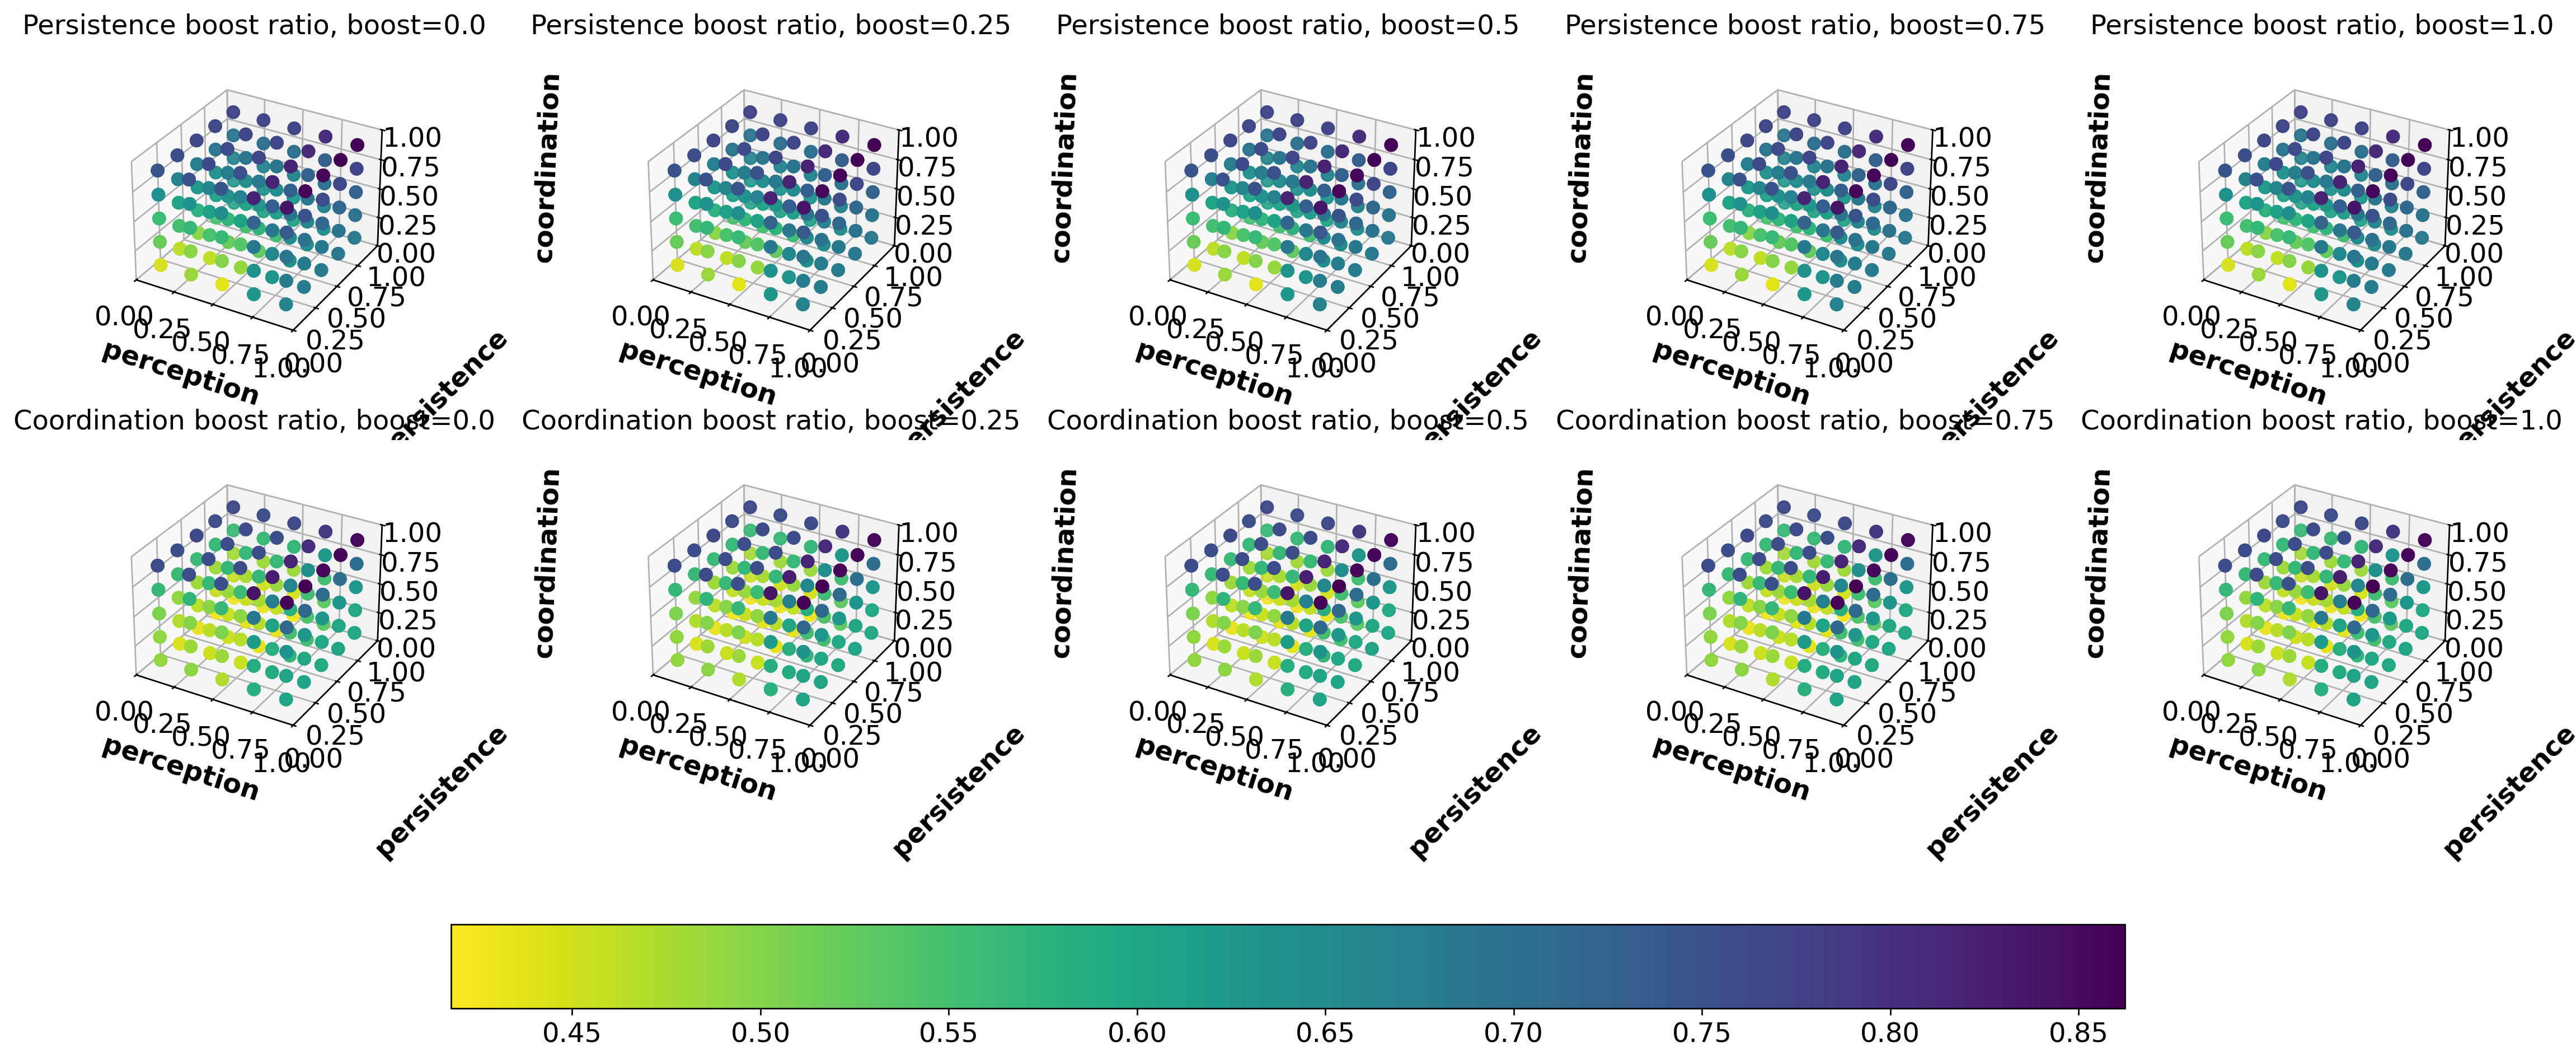

In [51]:
fig = plt.figure(figsize=(24, 10), dpi=240)

boost_values = results_df["persistence_boost_value"].unique()
N_COLS = len(boost_values)

for i, boost_value in enumerate(boost_values):
    boost_value = np.round(boost_value, 2)

    df = results_df
    df["success_steps"] = df["success_steps"].fillna(ITERATIONS)

    points = df.sort_values("success_steps")[
        [
            "perception",
            "persistence",
            "coordination",
            "persistence_boost_ratio",
            "coordination_boost_ratio",
        ]
    ].to_numpy()

    x, y, z, b_persist, b_coord = zip(*points)

    ax = fig.add_subplot(2, N_COLS, i + 1, projection="3d")

    plot = plot_params_3d(
        ax,
        x,
        y,
        z,
        title=f"Persistence boost ratio, boost={boost_value}",
        c=b_persist,
        # vmin=3 / 4 * ITERATIONS,
        # vmax=ITERATIONS,
    )

    ax = fig.add_subplot(2, N_COLS, N_COLS + i + 1, projection="3d")

    plot = plot_params_3d(
        ax,
        x,
        y,
        z,
        title=f"Coordination boost ratio, boost={boost_value}",
        c=b_coord,
        # vmin=3 / 4 * ITERATIONS,
        # vmax=ITERATIONS,
    )

axes = fig.axes

cbar = fig.colorbar(plot, ax=axes, shrink=0.67, location="bottom")
# fig.suptitle(f"Worst {LAST_PERCENT}% runs", size="20")
plt.show()

In [ ]:
for avg_steps in [20, 50, 100, 200, 500]:
    

(0.5780634676411606, 0.6014224990821514)

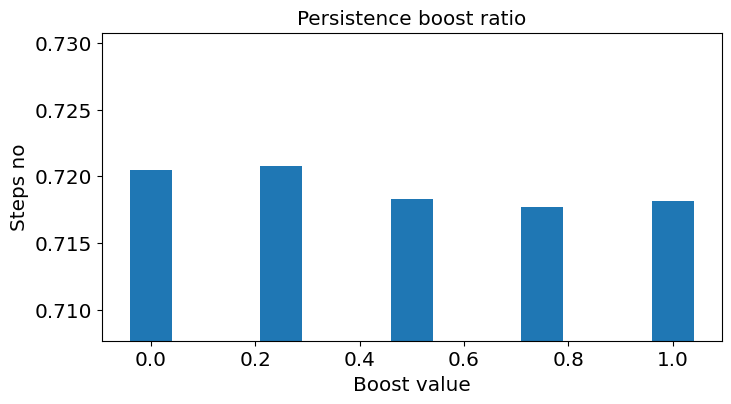

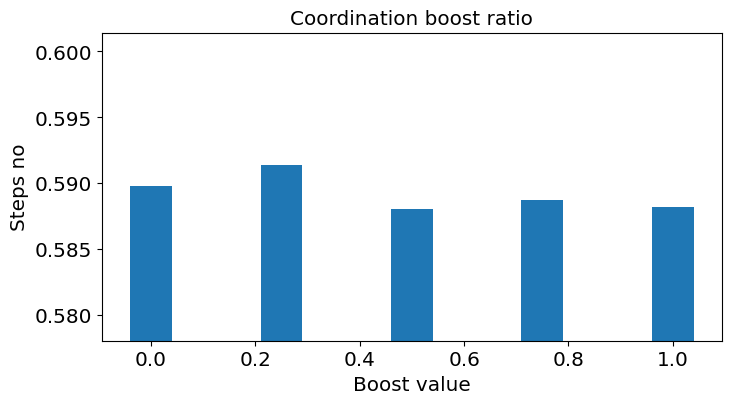

In [55]:
axis_x = []
persistence_boost_ratios = []
coordination_boost_ratios = []

for boost_value, row in results_df[
    ["persistence_boost_value", "persistence_boost_ratio", "coordination_boost_ratio"]
].groupby(by="persistence_boost_value"):
    axis_x.append(np.round(boost_value, 3))

    row = row.mean()

    persistence_boost_ratios.append(row["persistence_boost_ratio"])
    coordination_boost_ratios.append(row["coordination_boost_ratio"])


f, ax1 = plt.subplots(figsize=(8, 4))
ax1.bar(
    axis_x,
    persistence_boost_ratios,
    width=0.08,
)
ax1.set_xlabel("Boost value")
ax1.set_ylabel("Steps no")
ax1.set_title("Persistence boost ratio")
ax1.set_ylim(
    bottom=min(persistence_boost_ratios) - 0.01,
    top=max(persistence_boost_ratios) + 0.01,
)

f2, ax2 = plt.subplots(figsize=(8, 4))
ax2.bar(
    axis_x,
    coordination_boost_ratios,
    width=0.08,
)
ax2.set_xlabel("Boost value")
ax2.set_ylabel("Steps no")
ax2.set_title("Coordination boost ratio")
ax2.set_ylim(
    bottom=min(coordination_boost_ratios) - 0.01,
    top=max(coordination_boost_ratios) + 0.01,
)

(20000,)
(20000,)
(20000,)
(20000,)
(20000,)


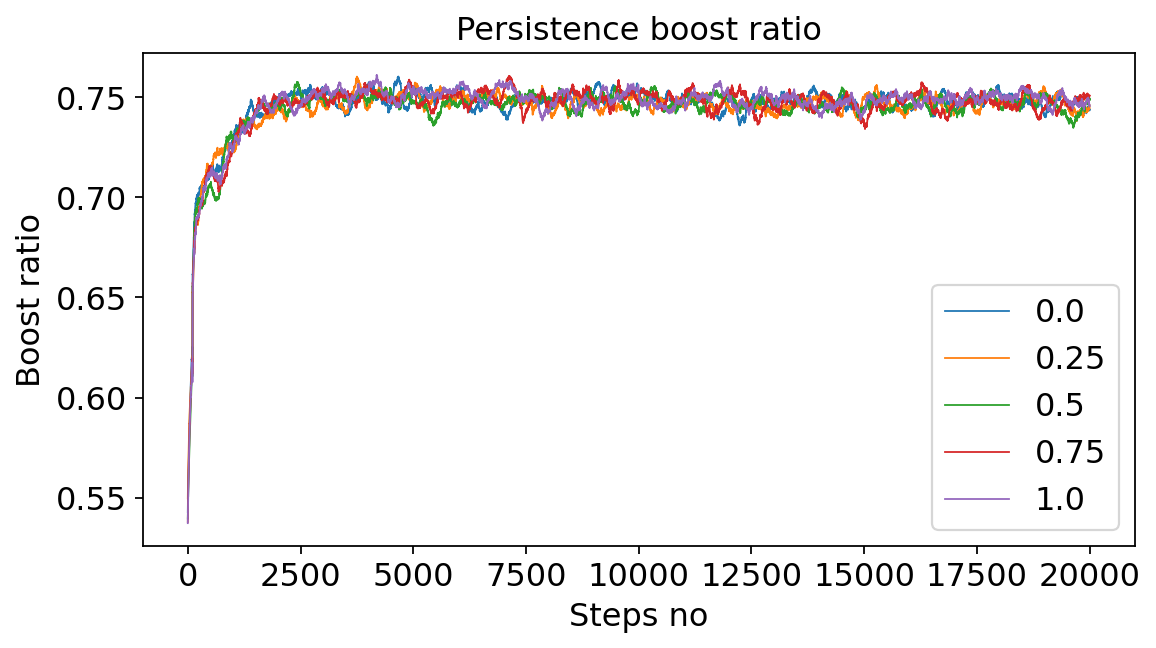

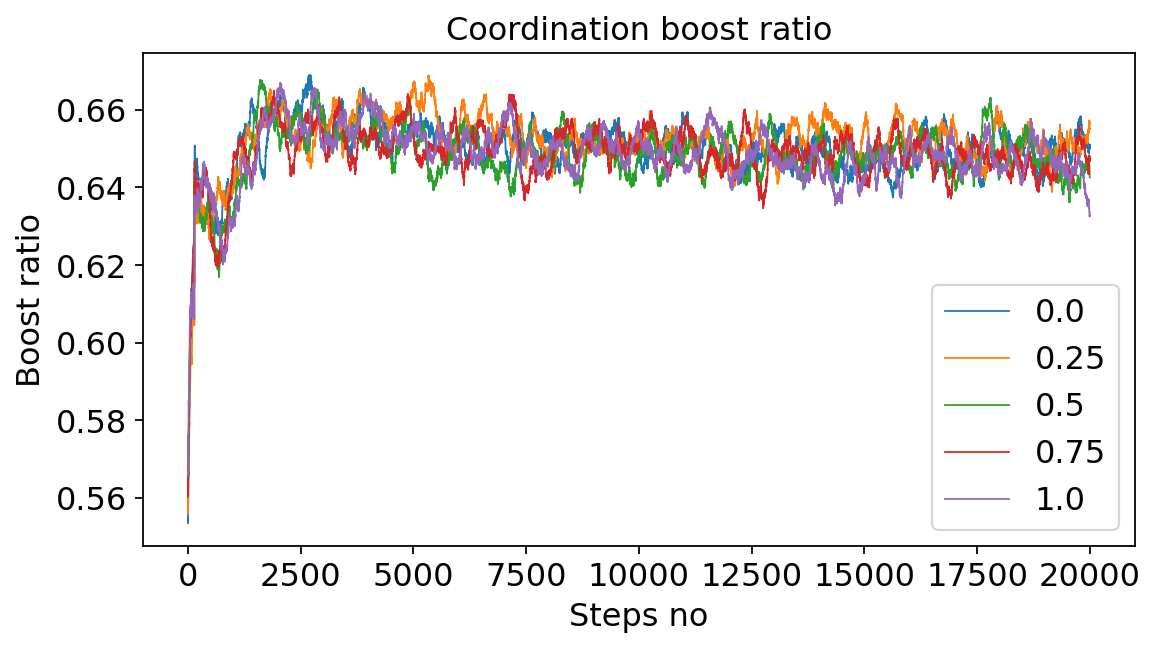

In [86]:
axis_x = []
persistence_boost_ratios = []
coordination_boost_ratios = []

f, ax1 = plt.subplots(figsize=(8, 4), dpi=160)
f2, ax2 = plt.subplots(figsize=(8, 4), dpi=160)

AVG_STEPS = 200

for boost_value, row in results_df[
    ["persistence_boost_value"] + new_column_names
].groupby(by="persistence_boost_value"):
    a = running_avg(
        np.average(np.array(row["persistence_boost_count"].to_list()), axis=0),
        AVG_STEPS,
    )
    b = running_avg(
        np.average(np.array(row["no_persistence_boost_count"].to_list()), axis=0),
        AVG_STEPS,
    )

    print(a.shape)

    persist_ratio = a / (a + b)

    ax1.plot(
        np.arange(len(persist_ratio)), persist_ratio, linewidth=0.8, label=boost_value
    )

    a = running_avg(
        np.average(np.array(row["coordination_boost_count"].to_list()), axis=0),
        AVG_STEPS,
    )
    b = running_avg(
        np.average(np.array(row["no_coordination_boost_count"].to_list()), axis=0),
        AVG_STEPS,
    )

    coord_ratio = a / (a + b)

    ax2.plot(np.arange(len(coord_ratio)), coord_ratio, linewidth=0.8, label=boost_value)


ax1.set_ylabel("Boost ratio")
ax1.set_xlabel("Steps no")
ax1.set_title("Persistence boost ratio")
# ax1.set_ylim(
#     bottom=min(persistence_boost_ratios) - 0.01,
#     top=max(persistence_boost_ratios) + 0.01,
# )
ax1.legend()

ax2.set_ylabel("Boost ratio")
ax2.set_xlabel("Steps no")
ax2.set_title("Coordination boost ratio")
ax2.legend()

# ax2.set_ylim(
#     bottom=min(coordination_boost_ratios) - 0.01,
#     top=max(coordination_boost_ratios) + 0.01,
# )
# persistence_boost_ratios.append(a / (a + b))

## Analyze derivative of goal distance (vs. boost value)

In [56]:
derivative_df = results_df


def get_derivative(index):
    results = load_partial(index).values()

    dists = np.array([r["goal_dist"] for r in results])

    gradient = np.gradient(dists, axis=0)
    return np.average(gradient, axis=0)


derivative_df["derivative"] = [
    get_derivative(index) for index in tqdm(results_df.index)
]
derivative_df.head()

100%|██████████| 625/625 [00:35<00:00, 17.42it/s]


perception  persistence  coordination  persistence_boost_value  \
0         0.1          0.1           0.1                     0.00   
1         0.1          0.1           0.1                     0.25   
2         0.1          0.1           0.1                     0.50   
3         0.1          0.1           0.1                     0.75   
4         0.1          0.1           0.1                     1.00   

   coordination_boost_value  success_steps  \
0                      0.00            NaN   
1                      0.25            NaN   
2                      0.50            NaN   
3                      0.75            NaN   
4                      1.00            NaN   

                                          derivative  
0  [-0.10360935840720552, -0.10360935840720552, -...  
1  [0.13730186812162126, 0.13730186812161999, 0.1...  
2  [-0.12394694394176203, -0.12394694394176237, -...  
3  [-0.15692442892141206, -0.1569244289214127, -0...  
4  [-0.013947061863471853, -0.013947061863471529,...

### Graph average derivative for all runs

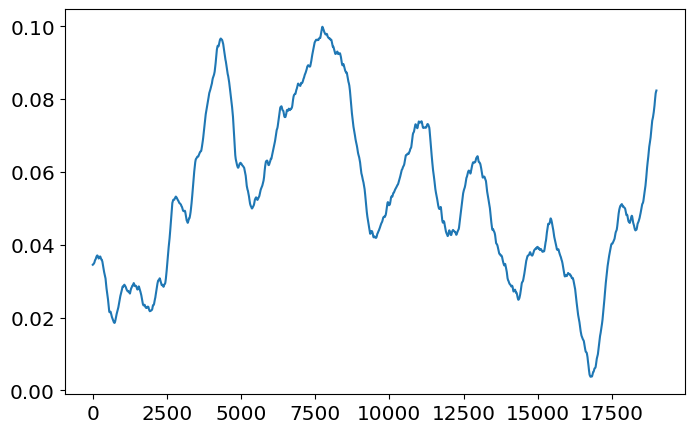

In [61]:
avg_derivative = np.array(derivative_df["derivative"].to_list())
avg_derivative = np.average(avg_derivative, axis=0)

plt.plot(running_avg(avg_derivative, 1000, m="valid"))

### Graph only successful runs

(226, 20000)


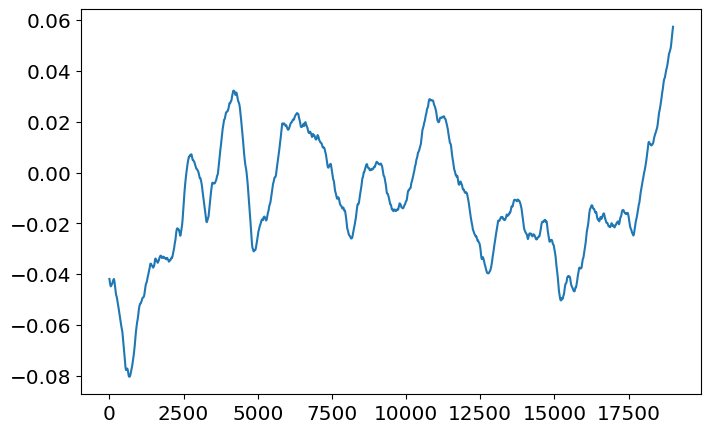

In [60]:
avg_derivative = np.array(
    derivative_df[derivative_df["success_steps"].notnull()]["derivative"].to_list()
)
print(avg_derivative.shape)
avg_derivative = np.average(avg_derivative, axis=0)

plt.plot(running_avg(avg_derivative, 1000, m="valid"))

## Moving average - TPS

In [116]:
def moving_average(a, n=3):
    # Add zeros at the beginning, so the result doesn't change dimensions
    a = np.concatenate([([0] * (n - 1)), a])

    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1 :] / n


def visualize_run(run, average_steps=500, extra_title=""):
    x = list(range(run["iterations"]))

    step_stats = run["goal_distance"]
    parent_stats = run["parent_tps"]
    infant_stats = run["infant_tps"]

    parent_stats = moving_average(parent_stats, average_steps)
    infant_stats = moving_average(infant_stats, average_steps)

    fig, ax1 = plt.subplots()

    ax1.plot(x, step_stats, color="r")
    ax1.set_ylim(bottom=0, top=50)
    ax1.set_ylabel("toy distance")
    ax1.set_xlabel("step")

    title = f'perc={run["perception"]:.2f}, pers={run["persistence"]:.2f}, \
coord={run["coordination"]:.2f},\n\
avg for {run["repeats"]} runs'

    if extra_title != "":
        title = extra_title + "\n" + title

    ax1.set_title(title)
    ax1.legend(["toy distance"], loc="lower right")

    ax2 = ax1.twinx()
    ax2.plot(x, parent_stats, color="b")
    ax2.set_ylabel("TPS")

    ax2.plot(x, infant_stats, color="orange")
    ax2.set_ylim(bottom=0)

    ax2.axvline(x=average_steps - 1, color="grey", label="axvline - full height")
    ax2.legend(["parent TPS", "infant TPS"], loc="upper right")

    x_ticks = np.append(ax1.get_xticks()[1:-1], average_steps)
    ax1.set_xticks(x_ticks)
    ax2.set_xticks(x_ticks)

    fig.tight_layout()
    # plt.savefig(f'../../plots/big_{current_param}.png', dpi=300)
    plt.show()

### Show a couple of randomly selected runs and see how they performed

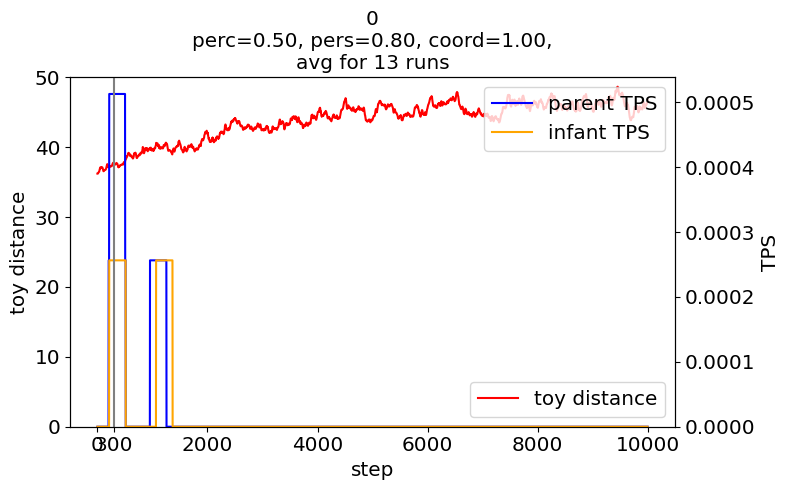

In [6]:
average_steps = 300

random_runs = np.random.choice(range(len(df)), size=1, replace=False)
for r in random_runs:
    visualize_run(df.iloc[r, :], extra_title=str(r), average_steps=average_steps)

## TPS - third person state

### 1. Using steps required to reach emergent action as a metric

### Add new column, which determines if the run was successful and if so - in how many steps the goal has been achieved

In [10]:
df["success_steps"] = df.apply(
    lambda row: get_success_step(row["goal_distance"], SUCCESS_DIST), axis=1
)
df.sort_values(by=["success_steps"]).head(16)

perception  persistence  coordination  repeats  iterations  \
15    0.900000     0.000000      0.100000       11       15000   
27    0.633333     0.366667      0.100000       11       15000   
31    0.633333     0.000000      0.100000       11       15000   
11    0.900000     0.366667      0.100000       11       15000   
23    0.633333     0.433333      0.100000       11       15000   
7     0.900000     0.433333      0.000000       11       15000   
30    0.633333     0.100000      0.366667       11       15000   
47    0.366667     0.100000      0.100000       11       15000   
19    0.633333     0.700000      0.100000       11       15000   
3     0.900000     0.700000      0.100000       11       15000   
43    0.366667     0.366667      0.100000       11       15000   
39    0.366667     0.433333      0.100000       11       15000   
10    0.900000     0.366667      0.366667       11       15000   
14    0.900000     0.000000      0.366667       11       15000   
0     0.900000     0.900000      0.900000       11       15000   
1     0.900000     0.900000      0.633333       11       15000   

                                        goal_distance  \
15  [36.160820030176815, 36.160820030176815, 36.15...   
27  [36.058102049644326, 36.058102049644326, 36.05...   
31  [36.10495501916605, 36.10495501916604, 36.1288...   
11  [35.98382655350573, 35.98382655350573, 35.9850...   
23  [35.85149045507967, 35.85149045507967, 35.8501...   
7   [36.22922171061668, 36.22922171061668, 36.2172...   
30  [35.79082090815256, 35.79082090815256, 35.8000...   
47  [36.09651950793614, 36.09651950793614, 36.0899...   
19  [36.14991388106114, 36.14991388106114, 36.1592...   
3   [36.206589466738414, 36.206589466738414, 36.21...   
43  [36.250849859894714, 36.250849859894714, 36.25...   
39  [36.43544148026676, 36.43544148026676, 36.4354...   
10  [36.126491707553015, 36.126491707553015, 36.14...   
14  [35.97042651559366, 35.97042651559366, 35.9666...   
0   [36.38576512405545, 36.38576512405545, 36.3969...   
1   [35.98344152290745, 35.98344152290745, 35.9814...   

                                           parent_tps  \
15  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
27  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
31  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
11  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
23  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
7   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
30  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
47  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
19  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
43  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
39  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
10  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
14  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
0   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                           infant_tps  success_steps  
15  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...          695.0  
27  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...          822.0  
31  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...          822.0  
11  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...          895.0  
23  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...          895.0  
7   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...          936.0  
30  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...         1312.0  
47  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...         1433.0  
19  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...         1595.0  
3   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...         1981.0  
43  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...         2785.0  
39  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...         8723.0  
10  [0.0, 0.0, 0.0

In [8]:
df.loc[:, "success_steps"].mean()

nan

### Show the histogram of minimum distance in each run, and histogram of the number of steps required to reach the goal

In [81]:
df.loc[:, "success_steps"].count()

874

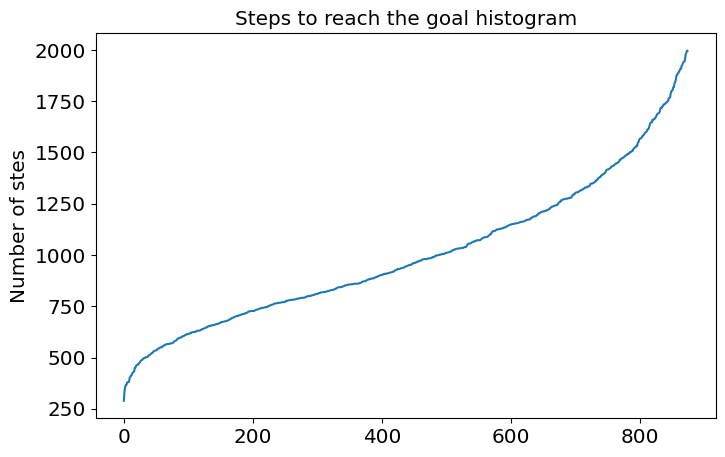

In [75]:
y = (
    df[df["success_steps"].notna()]
    .apply(lambda row: np.min(row["success_steps"]), axis=1)
    .sort_values()
    .to_numpy()
)

fig, ax = plt.subplots()
ax.plot(y)
ax.set_title("Steps to reach the goal histogram")
ax.set_ylabel("Number of stes")
plt.show()

### See how the best run performed, for different number of steps used in calculating the moving average
(the grey vertical line shows the number of steps used for calculating the average)

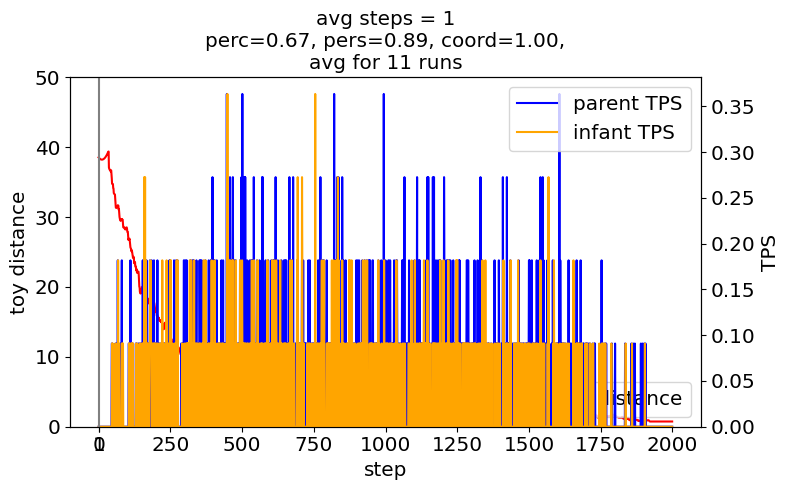

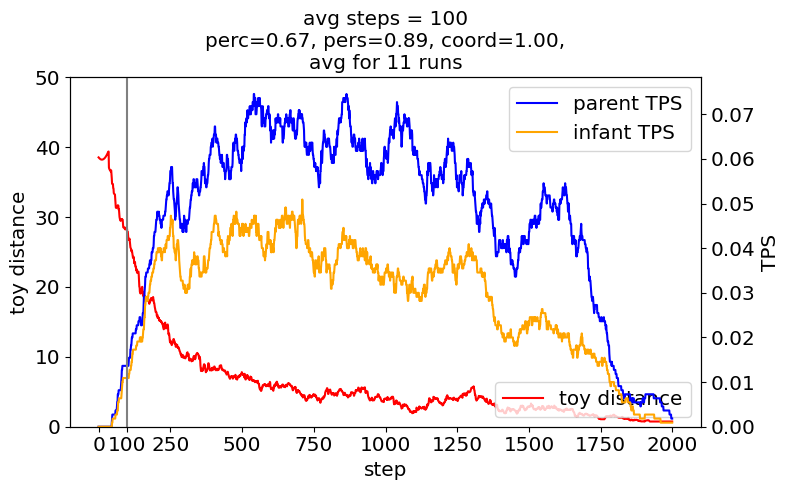

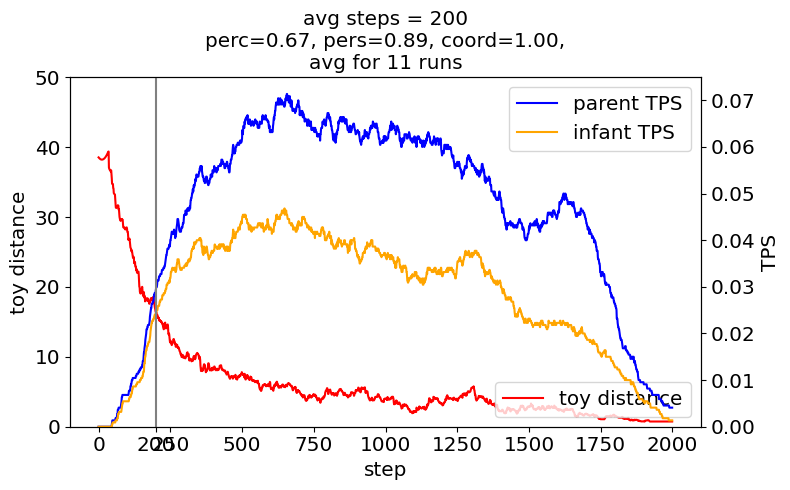

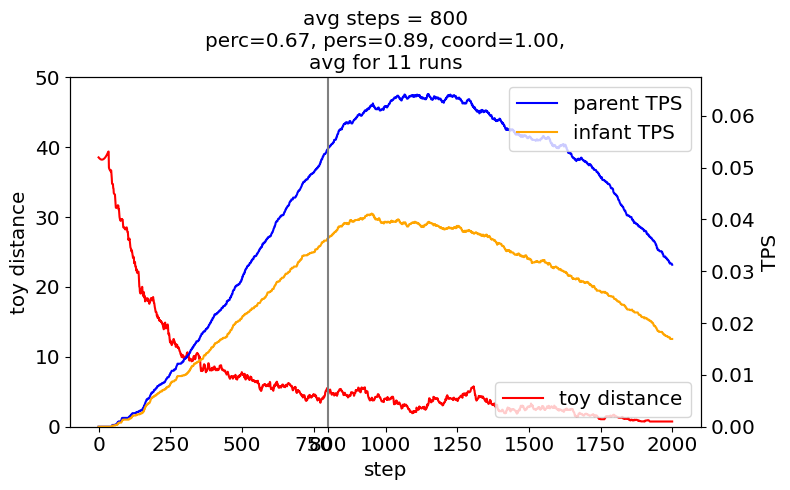

In [83]:
for steps in [1, 100, 200, 350, 800]:
    visualize_run(
        df.sort_values(by=["success_steps"]).iloc[0, :],
        average_steps=steps,
        extra_title=f"avg steps = {steps}",
    )

### Create heatmap for 2 variables
We define two ways of creating the heatmap:
1. Find 3 paramters which change the least in the top N runs and free the remaining two
2. Find the top 2 parameters that changed the least in the top N runs. Then group all data by those two parameters, averaging the remaining values - most importantly - the selected metric values

In [52]:
def get_heatmap_data_fixed(df, metric, top_runs_no, ascending=True):
    top_runs = df.sort_values(by=[metric], ascending=ascending).head(top_runs_no)

    params_data = []

    for param in ["perception", "persistence", "coordination"]:
        bincount = np.bincount(top_runs[param])
        count = np.max(bincount)
        value = np.argmax(bincount)

        params_data.append([param, value, count])

    params_df = pd.DataFrame(
        params_data, columns=["param", "best_value", "count"]
    ).sort_values("count", ascending=False)
    print(params_df)
    fixed_params = (
        params_df.head(1).loc[:, ["param", "best_value"]].to_numpy().reshape(2)
    )
    free_params = (
        params_df.tail(2).loc[:, ["param", "best_value"]].to_numpy().reshape(4)
    )

    p1, v1 = fixed_params
    param1, val1, param2, val2 = free_params

    selected_runs = df[(df[p1] == v1)]
    selected_runs = selected_runs.sort_values(by=[param1, param2])

    labels1 = selected_runs[param1].unique().round(3)
    labels2 = selected_runs[param2].unique().round(3)

    hm_data = selected_runs[metric].to_numpy().reshape(len(labels1), len(labels2)).T

    return hm_data, fixed_params, [param1, param2], [labels1, labels2]

In [48]:
def create_heatmap(heatmap_data, labelsx, labelsy, invert_colors=False, title=""):
    assert heatmap_data.shape == (len(labelsy), len(labelsx))

    colormap_data = np.nan_to_num(heatmap_data, nan=(np.nanmax(heatmap_data) + 100))

    fig, ax = plt.subplots(figsize=(8, 8))

    if invert_colors:
        cmap = matplotlib.colormaps["viridis_r"]
    else:
        cmap = matplotlib.colormaps["viridis"]
    im = ax.imshow(colormap_data, cmap=cmap)

    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(len(labelsx)), labels=labelsx)
    ax.set_yticks(np.arange(len(labelsy)), labels=labelsy)

    ax.set_xlabel(param1)
    ax.set_ylabel(param2)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(labelsx)):
        for j in range(len(labelsy)):
            text = ax.text(
                i,
                j,
                heatmap_data[j, i],
                ha="center",
                va="center",
                color="w",
                fontsize=14,
            )

    ax.set_title(title)
    fig.tight_layout()
    plt.show()

### Show the heatmap for the fixed 3 parameters, which were the most common in the top 30 runs

          param  best_value  count
2  coordination           0     30
0    perception           0     25
1   persistence           0     21


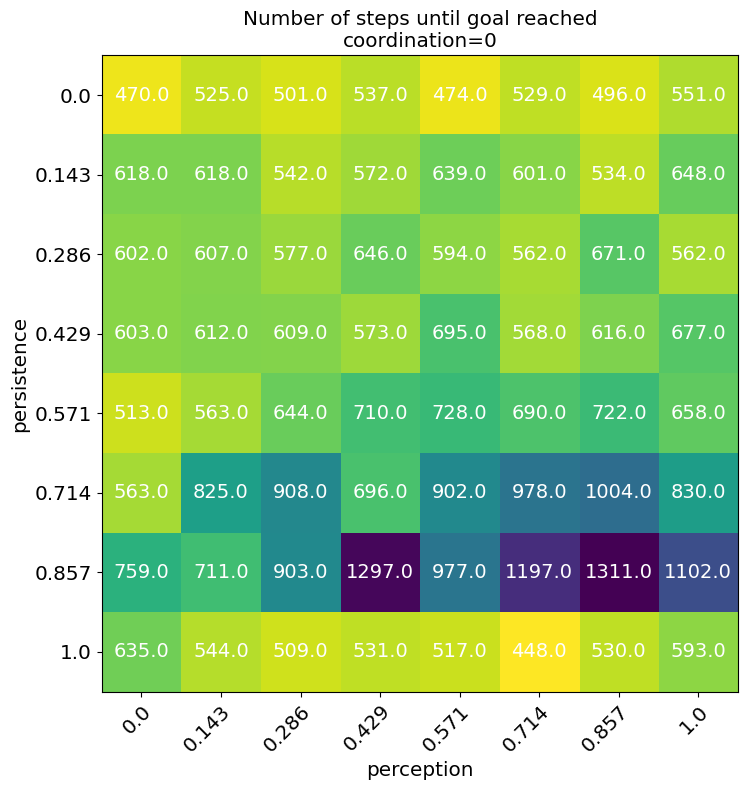

In [53]:
(
    hm_data,
    [p1, v1],
    [param1, param2],
    [labels1, labels2],
) = get_heatmap_data_fixed(df, "success_steps", top_runs_no=30)
title = f"Number of steps until goal reached\n{p1}={v1}"
create_heatmap(hm_data, labels1, labels2, invert_colors=True, title=title)

### Using TPS (third-party state) measure as a metric

Let's define two metrics - maximum TPS throughout the run, and TPS at the end of the run. 
Both values will be calculated using the moving average.
We will measure the TPS for parent and infant separately.

In [23]:
average_steps = 500

In [15]:
def moving_average(a, n=3):
    # Add zeros at the beginning, so the result doesn't change dimensions
    a = np.concatenate([([0] * (n - 1)), a])

    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1 :] / n

In [24]:
df_tps = df.copy()

df_tps["parent_tps_max"] = df.apply(
    lambda row: moving_average(row["parent_satisfaction"], n=average_steps).max(),
    axis=1,
)
df_tps["parent_tps_end"] = df.apply(
    lambda row: moving_average(row["parent_satisfaction"], n=average_steps)[-1], axis=1
)
df_tps["infant_tps_max"] = df.apply(
    lambda row: moving_average(row["infant_satisfaction"], n=average_steps).max(),
    axis=1,
)
df_tps["infant_tps_end"] = df.apply(
    lambda row: moving_average(row["infant_satisfaction"], n=average_steps)[-1], axis=1
)

In [25]:
new_df = df_tps.groupby(["coordination", "precision"]).mean(numeric_only=True)
new_df

width  height  speed  lego_count  exploration  \
coordination precision                                                  
0.0          20.0       300.0   300.0    2.0         4.0         50.0   
             40.0       300.0   300.0    2.0         4.0         50.0   
             60.0       300.0   300.0    2.0         4.0         50.0   
             80.0       300.0   300.0    2.0         4.0         50.0   
             100.0      300.0   300.0    2.0         4.0         50.0   
25.0         20.0       300.0   300.0    2.0         4.0         50.0   
             40.0       300.0   300.0    2.0         4.0         50.0   
             60.0       300.0   300.0    2.0         4.0         50.0   
             80.0       300.0   300.0    2.0         4.0         50.0   
             100.0      300.0   300.0    2.0         4.0         50.0   
50.0         20.0       300.0   300.0    2.0         4.0         50.0   
             40.0       300.0   300.0    2.0         4.0         50.0   
             60.0       300.0   300.0    2.0         4.0         50.0   
             80.0       300.0   300.0    2.0         4.0         50.0   
             100.0      300.0   300.0    2.0         4.0         50.0   
75.0         20.0       300.0   300.0    2.0         4.0         50.0   
             40.0       300.0   300.0    2.0         4.0         50.0   
             60.0       300.0   300.0    2.0         4.0         50.0   
             80.0       300.0   300.0    2.0         4.0         50.0   
             100.0      300.0   300.0    2.0         4.0         50.0   
100.0        20.0       300.0   300.0    2.0         4.0         50.0   
             40.0       300.0   300.0    2.0         4.0         50.0   
             60.0       300.0   300.0    2.0         4.0         50.0   
             80.0       300.0   300.0    2.0         4.0         50.0   
             100.0      300.0   300.0    2.0         4.0         50.0   

                        responsiveness  relevance  repeats  max_iter  \
coordination precision                                                 
0.0          20.0                 50.0       50.0    100.0    5000.0   
             40.0                 50.0       50.0    100.0    5000.0   
             60.0                 50.0       50.0    100.0    5000.0   
             80.0                 50.0       50.0    100.0    5000.0   
             100.0                50.0       50.0    100.0    5000.0   
25.0         20.0                 50.0       50.0    100.0    5000.0   
             40.0                 50.0       50.0    100.0    5000.0   
             60.0                 50.0       50.0    100.0    5000.0   
             80.0                 50.0       50.0    100.0    5000.0   
             100.0                50.0       50.0    100.0    5000.0   
50.0         20.0                 50.0       50.0    100.0    5000.0   
             40.0                 50.0       50.0    100.0    5000.0   
             60.0                 50.0       50.0    100.0    5000.0   
             80.0                 50.0       50.0    100.0    5000.0   
             100.0                50.0       50.0    100.0    5000.0   
75.0         20.0                 50.0       50.0    100.0    5000.0   
             40.0                 50.0       50.0    100.0    5000.0   
             60.0                 50.0       50.0    100.0    5000.0   
             80.0                 50.0       50.0    100.0    5000.0   
             100.0                50.0       50.0    100.0    5000.0   
100.0        20.0                 50.0       50.0    100.0    5000.0   
             40.0                 50.0       50.0    100.0    5000.0   
             60.0                 50.0       50.0    100.0    5000.0   
             80.0                 50.0       50.0    100.0    5000.0   
             100.0                50.0       50.0    100.0    5000.0   

                        success_steps  parent_tps_max  parent_tps_end  \
coordination precision            

### Repeat all of the above, using the four newly created metrics
For each metric (`tps_max` / `tps_end`), (`parent` / `infant`) plot the run with the best result and the two types of heatmap

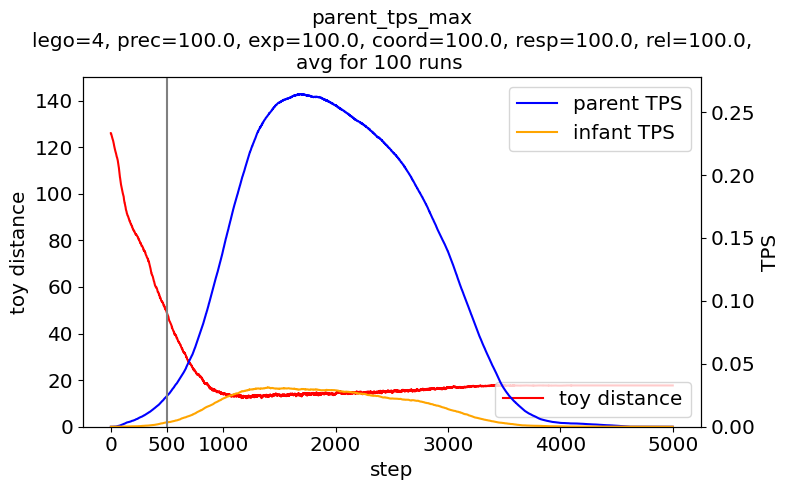

            param  best_value  count
2       relevance         100     30
3  responsiveness         100     30
0       precision         100     15
4    coordination         100     13
1     exploration          75     11


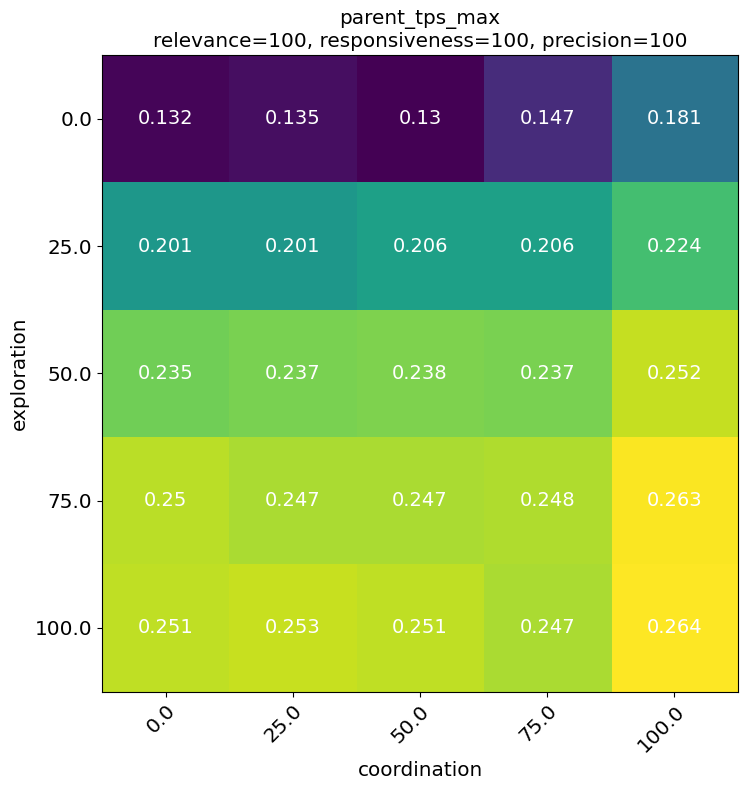

            param  best_value  count
2       relevance         100     30
3  responsiveness         100     19
4    coordination         100     18
0       precision          20     15
1     exploration          50      9


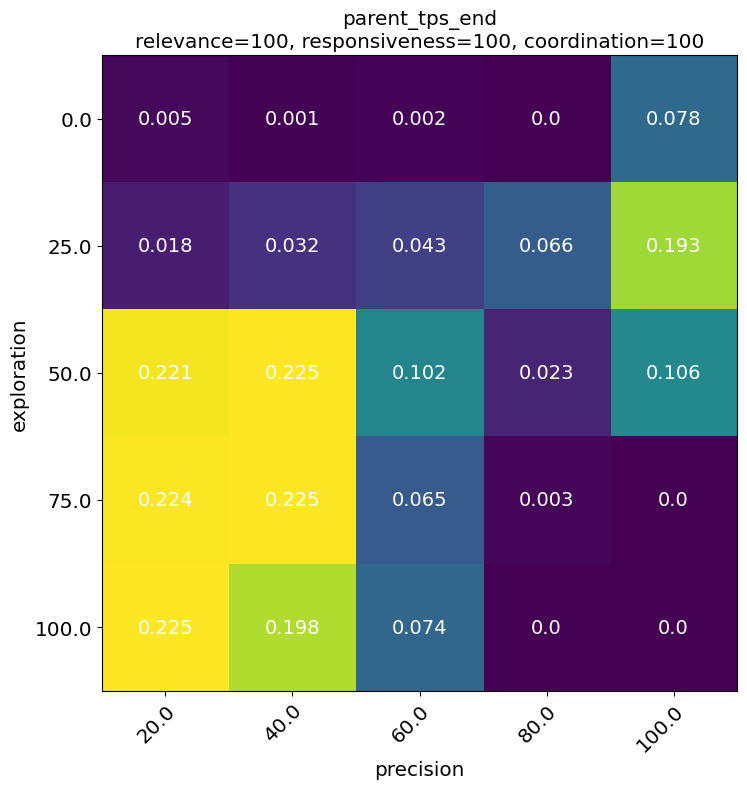

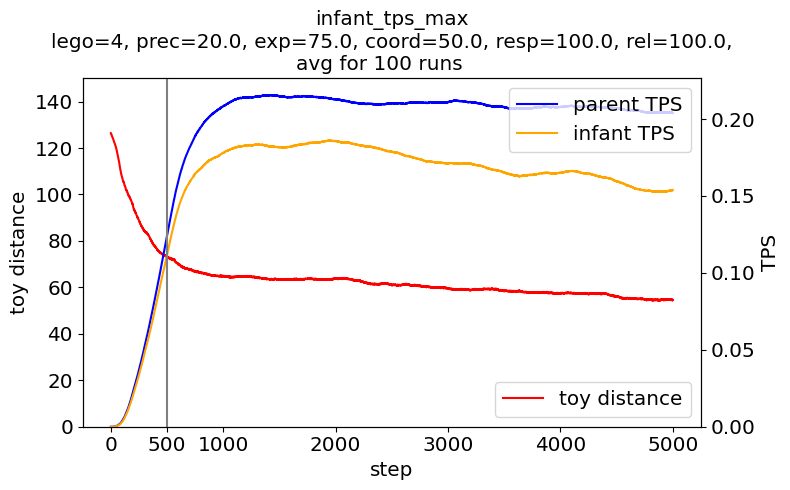

            param  best_value  count
3  responsiveness         100     30
0       precision          20     24
4    coordination         100     18
2       relevance         100     16
1     exploration          50      8


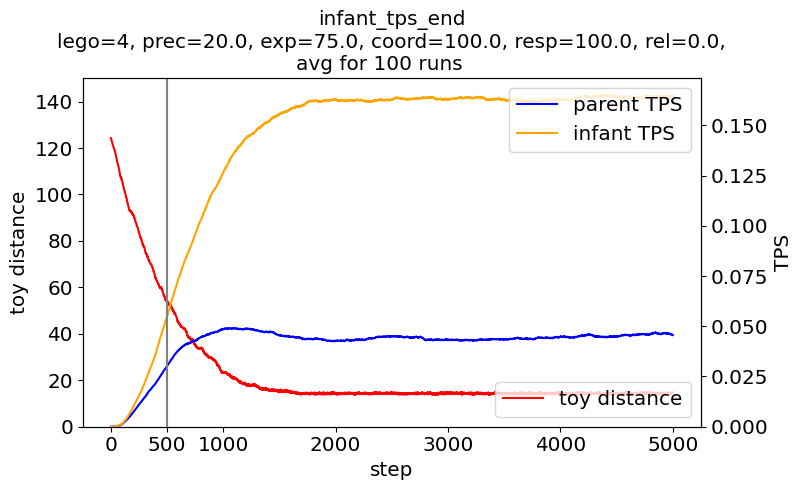

            param  best_value  count
3  responsiveness         100     30
4    coordination         100     24
0       precision          20     16
2       relevance           0     15
1     exploration          75      9


In [30]:
for agent in ["parent", "infant"]:
    for kind in ["max", "end"]:
        metric = agent + "_tps_" + kind
        visualize_run(
            df_tps.sort_values(by=[metric], ascending=False).iloc[0, :],
            average_steps=average_steps,
            extra_title=metric,
        )

        (
            hm_data,
            [p1, v1, p2, v2, p3, v3],
            [param1, param2],
            [labels1, labels2],
        ) = get_heatmap_data_fixed(df_tps, metric, top_runs_no=30, ascending=False)
        title = f"{metric}\n{p1}={v1}, {p2}={v2}, {p3}={v3}"
        create_heatmap(hm_data.round(3), labels1, labels2, title=title)